In [7]:
import re
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
from datetime import datetime, timedelta
from datetime import date
import requests
from tqdm import tqdm
from scipy import stats
import numpy as np
from IPython.display import display
from matplotlib import gridspec
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import PolynomialFeatures

warnings.simplefilter('ignore', ConvergenceWarning)

sns.set()
plt.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False

# Preprocessing

## Promotion data

In [8]:
# Preprocess promotion data
bd_data_path = "./data/promotion_data.xlsx"
xls = pd.ExcelFile(bd_data_path)
promotion_df = pd.read_excel(xls, "Sheet1", header=[0, 1], index_col=[0])
xls.close()

desc_regex = r"\((.*?)\)"

error_list = []
event_dict_list = []
for year in [2021, 2022, 2023]:
    promotion_year_df = promotion_df[year]

    for region, row in promotion_year_df.iterrows():
        events_list = [e for e in row.values if e is not np.nan]
        events_list = [item.split('\n') for item in events_list]
        events_list = [item for sublist in events_list for item in sublist]
        for events in events_list:
            event_list = events.replace(" ", "").split("/")
            for i, e in enumerate(event_list):
                try:
                    matches = re.findall(desc_regex, e)
                    desc_text = matches[0] if len(matches) > 0 else ""

                    date_text = re.sub(desc_regex, "", e)
                    if date_text == "연중":
                        start_date = np.datetime64(date(year, 1, 1))
                        end_date = np.datetime64(date(year, 12, 31))
                    else:
                        if len(date_text.split("~")) == 1:
                            continue
                        start_date, end_date = date_text.split("~")
                        start_date = datetime.strptime(start_date.rstrip('.'), "%m.%d").replace(year=year)
                        end_date = datetime.strptime(end_date.rstrip('.'), "%m.%d").replace(year=year)
                        if start_date > end_date:
                            if i < len(events_list) // 2:
                                start_date = start_date.replace(year=year - 1)
                            else:
                                end_date = end_date.replace(year=year + 1)

                    event_dict_list.append(
                        {"year": year, "region": region, "start": start_date, "end": end_date, "desc": desc_text})
                except ValueError:
                    error_list.append([year, region, date_text])
promotion_df = pd.DataFrame(event_dict_list)

In [9]:
promotion_dates_df = {}

promotion_dates_index = pd.date_range(promotion_df['start'].min(), "2023-08-31")

regions = promotion_df["region"].unique()
for i, region in enumerate(regions):
    temp_promo_df = promotion_df[(promotion_df["region"] == region)]

    promotion_dates = pd.Series(index=promotion_dates_index, dtype=int)
    for _, row in temp_promo_df.iterrows():
        mask = (promotion_dates.index >= row['start']) & (promotion_dates.index <= row['end'])
        promotion_dates[mask] = 1

    promotion_dates_df[region] = promotion_dates
promotion_dates_df = pd.DataFrame(promotion_dates_df).fillna(0).astype(dtype=np.int8)
# promotion_dates_df = promotion_dates_df[promotion_dates_df.index.slice_indexer(None, "2023-08-31")]
display(promotion_dates_df)

,본부(전국공동),서울중앙,서울남부,서울동부,부산,대구경북,인천,울산,경기,강원,충북,대전세종충남,전북,광주전남,경남,제주
2021-01-01,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0
2021-01-02,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0
2021-01-03,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0
2021-01-04,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0
2021-01-05,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-27,0,1,1,1,1,1,1,0,1,0,1,0,1,0,0,0
2023-08-28,0,1,1,1,1,0,1,0,1,0,0,0,0,0,0,0
2023-08-29,0,1,1,1,1,0,1,0,1,0,0,0,0,0,0,0
2023-08-30,0,1,1,1,1,0,1,0,1,0,0,0,0,0,0,0


## Special Promotion data

In [10]:
special_promotions_df = pd.read_csv("./data/special_promotions_filtered.csv", encoding="utf8")
special_promotions_df["period_start"] = pd.to_datetime(special_promotions_df["period_start"], format="%Y.%m.%d")
special_promotions_df["period_end"] = pd.to_datetime(special_promotions_df["period_end"], format="%Y.%m.%d")
special_promotions_df["wrote_date"] = pd.to_datetime(special_promotions_df["wrote_date"], format="%Y.%m.%d")

special_promotions_df["period_days"] = (special_promotions_df["period_end"] - special_promotions_df[
    "period_start"]).dt.days + 1

promo_mask = (special_promotions_df["period_start"] > "2021-1-1") & (special_promotions_df["period_end"] < "2023-7-31")
special_promotions_df = special_promotions_df[promo_mask]
display(special_promotions_df)

,id,location,title,url,period_start,period_end,institution,wrote_date,hits,period_days
151,160,지역,(서울중앙혈액원)목동센터 개소 N주년 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2023-07-27,2023-07-29,서울중앙,2023-07-26,1714,3
152,161,지역,(서울중앙혈액원)대화역센터 개소 N주년 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2023-07-20,2023-07-22,서울중앙,2023-07-18,1387,3
158,167,지역,[서울중앙혈액원] 구로디지털단지역센터 개소 N주년 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2023-07-17,2023-07-19,서울중앙,2023-07-14,2677,3
160,169,지역,[서울중앙혈액원] 영화 밀수 시사회 응모 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2023-07-12,2023-07-13,서울중앙,2023-07-11,5432,2
161,170,지역,[서울중앙혈액원] 중앙센터 개소 N주년 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2023-07-12,2023-07-14,서울중앙,2023-07-10,4530,3
...,...,...,...,...,...,...,...,...,...,...
441,468,전국,4월에서 5월까지 헌혈해봄 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2021-04-19,2021-05-18,혈액관리본부,2021-04-21,48911,30
442,469,전국,나눔테크와 함께하는 생명지킴 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2021-04-21,2021-05-18,혈액관리본부,2021-04-21,37636,28
443,470,전국,씨월드고속훼리와 제주혈액원이 함께하는 헌혈자를 위한 가치나눔 프로젝트,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2021-04-01,2021-12-31,혈액관리본부,2021-04-09,68151,275
444,471,전국,넥센타이어와 함께하는 봄맞이 생명안전 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2021-04-01,2021-05-31,혈액관리본부,2021-04-01,35326,61


## Weather data

In [11]:
# Preprocess Weather data
weather_data_path = "./data/weather_country.csv"

weather_df = pd.read_csv(weather_data_path, encoding='cp949')
weather_df = weather_df.fillna(0)
weather_df["date"] = weather_df["date"].astype("datetime64[ns]")
weather_df = weather_df.drop("code", axis=1)
weather_df = weather_df.set_index("date")
display(weather_df)

,location,temp,rainfall
date,,,
2018-01-01,강원,-4.5,0.0
2018-01-02,강원,-3.5,0.0
2018-01-03,강원,-5.6,0.0
2018-01-04,강원,-6.1,0.0
2018-01-05,강원,-4.2,0.0
...,...,...,...
2023-07-27,경남,29.9,0.0
2023-07-28,경남,30.1,0.0
2023-07-29,경남,30.4,0.0


## Daily blood donation/stock/usage data

In [12]:
# Daily blood donation
bd_data_path = "./data/daily_blood_donation_data.xls"
xls = pd.ExcelFile(bd_data_path)
print(xls.sheet_names)

daily_bd_sheets = []
for sheet_name in xls.sheet_names[1:]:
    df = pd.read_excel(xls, sheet_name)
    daily_bd_sheets.append(df)
xls.close()
daily_bd_df = pd.concat(daily_bd_sheets)

eng_columns_dict = {
    "일자": "date",
    "성별": "gender",
    "혈액원별": "region",
    "헌혈방법": "method",
    "혈액형": "type",
    "건수": "count"}
daily_bd_df = daily_bd_df.rename(columns=eng_columns_dict)

daily_bd_df["region"] = daily_bd_df["region"].str.replace(" ", "")
daily_bd_df["region"] = daily_bd_df["region"].str.replace(".", "")

# seoul_region_dict = {"서울남부": "서울", "서울동부": "서울", "서울서부": "서울", "서울중앙": "서울"}
# daily_bd_df['region'] = daily_bd_df['region'].replace(seoul_region_dict)

# Daily blood Stock
bs_data_path = "./data/daily_blood_stock.xlsx"
xls = pd.ExcelFile(bs_data_path)
daily_bs_df = pd.read_excel(xls, xls.sheet_names[0])
xls.close()

daily_bs_df = pd.melt(daily_bs_df, id_vars=daily_bs_df.columns[:2], value_vars=daily_bs_df.columns[2:], var_name="혈액형",
                      value_name="건수")
eng_columns_dict = {
    "일자": "date",
    "혈액제제": "product",
    "혈액형": "type",
    "건수": "count"}
daily_bs_df = daily_bs_df.rename(columns=eng_columns_dict)
daily_bs_df[daily_bs_df["count"] == "2 이하"] = 0

# Daily blood usage
bd_data_path = "./data/daily_blood_usage.xlsx"
xls = pd.ExcelFile(bd_data_path)
daily_bu_df = pd.read_excel(xls, xls.sheet_names[0])
xls.close()

daily_bu_df = daily_bu_df.rename(columns={"일자": "date"})

['요청', '2018(1)', '2018(2)', '2019(1)', '2019(2)', '2020(1)', '2020(2)', '2021(1)', '2021(2)', '2022(1)', '2022(2)', '2023(1)', '2023(2)']


## Compress

In [13]:
# compress data
def chk_mem_saving(series, dtype):
    org_mem_use = series.memory_usage(index=False, deep=True) / (2 ** (10 * 2))
    new_mem_use = series.astype(dtype).memory_usage(index=False, deep=True) / (2 ** (10 * 2))
    print(f"{series.name:<13}: {org_mem_use:<6.2f}MB => {new_mem_use:<6.2f}MB, "
          f"{(org_mem_use - new_mem_use) / org_mem_use * 100:.2f}% saved")


print(f"df memory usage: {daily_bd_df.memory_usage(deep=True).sum() / (2 ** (10 * 2)):.2f} MB")

dtypes_dict = {
    "date": "datetime64[ns]",
    "gender": "category",
    "region": "category",
    "method": "category",
    "type": "category",
    "count": "int16"
}
for column_name, dtype in dtypes_dict.items():
    chk_mem_saving(daily_bd_df[column_name], dtype)
daily_bd_df = daily_bd_df.astype(dtypes_dict)

print(f"bd_df memory usage: {daily_bd_df.memory_usage(deep=True).sum() / (2 ** (10 * 2)):.2f} MB")

# blood stock
print(f"bs_df memory usage: {daily_bs_df.memory_usage(deep=True).sum() / (2 ** (10 * 2)):.2f} MB")

dtypes_dict = {
    "date": "datetime64[ns]",
    "product": "category",
    "type": "category",
    "count": "int32"
}
for column_name, dtype in dtypes_dict.items():
    chk_mem_saving(daily_bs_df[column_name], dtype)
daily_bs_df = daily_bs_df.astype(dtypes_dict)

print(f"bs_df memory usage: {daily_bs_df.memory_usage(deep=True).sum() / (2 ** (10 * 2)):.2f} MB")
daily_bs_df = daily_bs_df.set_index("date")

# blood usage
print(f"bu_df memory usage: {daily_bu_df.memory_usage(deep=True).sum() / (2 ** (10 * 2)):.2f} MB")

dtypes_dict = {
    "date": "datetime64[ns]",
    "A": "int32",
    "B": "int32",
    "AB": "int32",
    "O": "int32"
}
for column_name, dtype in dtypes_dict.items():
    chk_mem_saving(daily_bu_df[column_name], dtype)
daily_bu_df = daily_bu_df.astype(dtypes_dict)

print(f"bu_df memory usage: {daily_bu_df.memory_usage(deep=True).sum() / (2 ** (10 * 2)):.2f} MB")
daily_bu_df = daily_bu_df.set_index("date")

df memory usage: 270.86 MB
date         : 44.68 MB => 5.34  MB, 88.06% saved
gender       : 56.02 MB => 0.67  MB, 98.81% saved
region       : 58.73 MB => 0.67  MB, 98.86% saved
method       : 61.93 MB => 0.67  MB, 98.92% saved
type         : 38.82 MB => 0.67  MB, 98.28% saved
count        : 5.34  MB => 1.33  MB, 75.00% saved
bd_df memory usage: 14.68 MB
bs_df memory usage: 13.80 MB
date         : 5.22  MB => 0.37  MB, 92.85% saved
product      : 4.18  MB => 0.05  MB, 98.86% saved
type         : 2.72  MB => 0.05  MB, 98.27% saved
count        : 1.68  MB => 0.19  MB, 88.89% saved
bs_df memory usage: 0.65 MB
bu_df memory usage: 0.19 MB
date         : 0.13  MB => 0.02  MB, 88.06% saved
A            : 0.02  MB => 0.01  MB, 50.00% saved
B            : 0.02  MB => 0.01  MB, 50.00% saved
AB           : 0.02  MB => 0.01  MB, 50.00% saved
O            : 0.02  MB => 0.01  MB, 50.00% saved
bu_df memory usage: 0.05 MB


# EDA

## Promotion dates

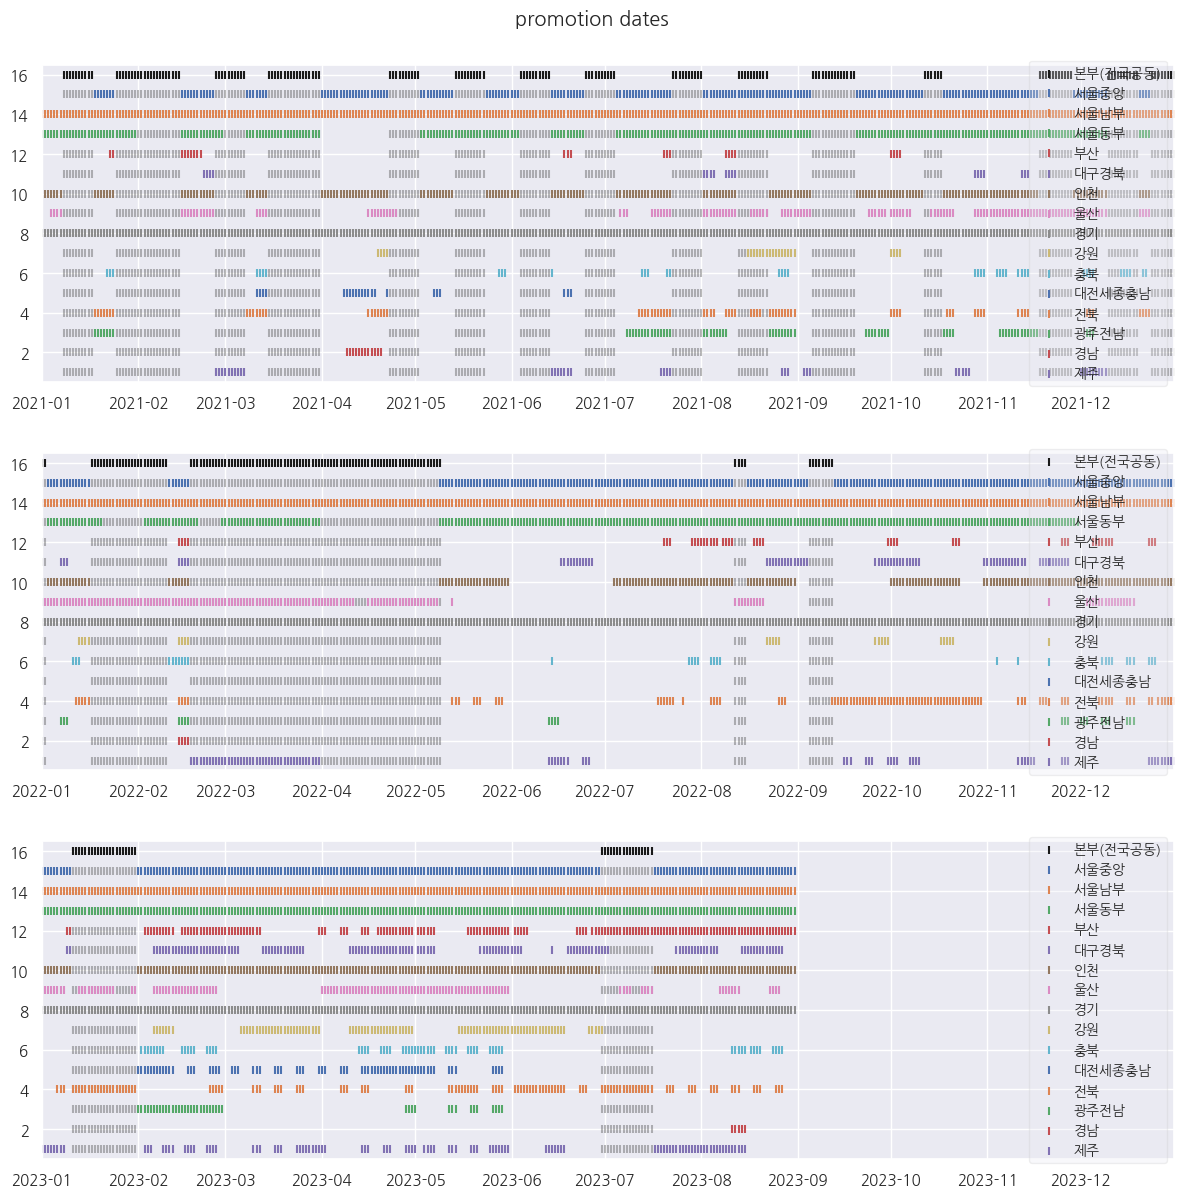

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12.2))
fig.suptitle("promotion dates")

for i, ax in enumerate(axs):
    for j, region in enumerate(promotion_dates_df.columns):
        region_promotion = promotion_dates_df[region]
        ax.scatter(region_promotion.index, promotion_dates_df["본부(전국공동)"].values * (len(regions) - j), alpha=0.3,
                   c="k", marker="|")
        ax.scatter(region_promotion.index, region_promotion.values * (len(regions) - j), label=region,
                   c="k" if region == "본부(전국공동)" else None, marker="|")
    ax.legend(loc=5, fontsize=10, framealpha=0.3, )
    ax.set_xlim([date(2021 + i, 1, 1), date(2021 + i, 12, 31)])
    ax.set_ylim([0.5, len(regions) + 0.5])
plt.tight_layout()
plt.show()

In [15]:
# 프로모션 + 전체데이터 통합
daily_bd_promo_df = daily_bd_df.copy()
daily_bd_promo_df = daily_bd_promo_df[(daily_bd_promo_df["date"] > min(promotion_dates_df.index)) & (
            daily_bd_promo_df["date"] < max(promotion_dates_df.index))]

daily_bd_promo_df["promotion"] = daily_bd_promo_df.apply(lambda row: (
            (promotion_dates_df.loc[row["date"].strftime("%Y-%m-%d"), row["region"]]) | (
    promotion_dates_df.loc[row["date"].strftime("%Y-%m-%d"), "본부(전국공동)"])), axis=1)

## Promotion ratio / differences in distributions

In [16]:
promotion_bd_list = []
for region in promotion_dates_df.columns[1:]:
    promo_bd_group = daily_bd_df[daily_bd_df["region"] == region].groupby(by=["date", "method"])[
        "count"].sum().reset_index() \
        .pivot(index="date", columns="method", values="count").fillna(0)
    promo_bd_group = promo_bd_group[
        promo_bd_group.index.slice_indexer(min(promotion_dates_df.index), max(promotion_dates_df.index))]

    promotion_mask = promotion_dates_df["본부(전국공동)"].astype(bool) | promotion_dates_df[region].astype(bool)
    data_temp_dict = {"count": (promo_bd_group["전혈 320ml"] + promo_bd_group["전혈 400ml"]).values,
                      "region": [region] * len(promo_bd_group),
                      "promotion": promotion_mask.reindex(promo_bd_group.index),
                      }

    promotion_bd_temp_df = pd.DataFrame(index=promo_bd_group.index, data=data_temp_dict)
    promotion_bd_list.append(promotion_bd_temp_df)
promotion_bd_df = pd.concat(promotion_bd_list)

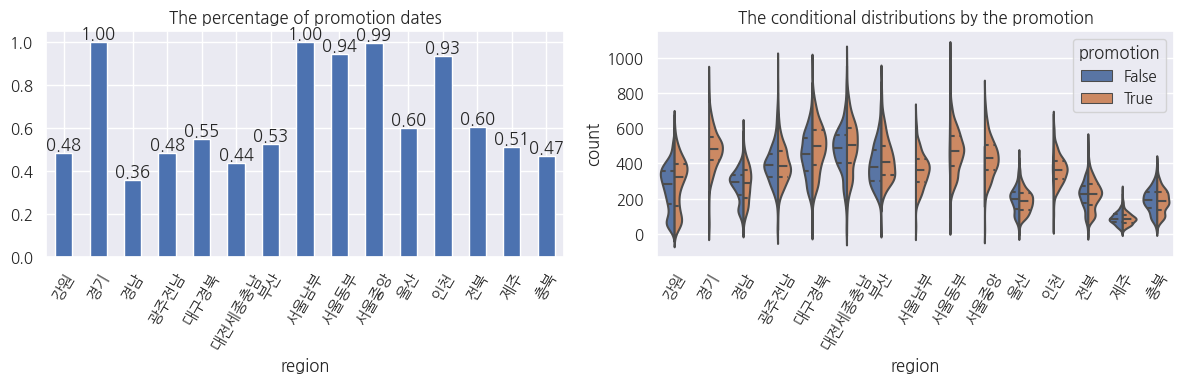

In [17]:
_, axs = plt.subplots(1, 2, figsize=(12, 4))

promotion_ratio_by_region = promotion_bd_df.groupby(by=["region"])["promotion"].mean().sort_index()
promotion_ratio_by_region.plot.bar(title="The percentage of promotion dates", ax=axs[0])
axs[0].bar_label(axs[0].containers[0], fmt="%.2f")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=60)

sns.violinplot(x="region", y="count", hue="promotion", data=promotion_bd_df.sort_values("region"), split=True,
               inner="quart", scale="count", ax=axs[1])
axs[1].set_title("The conditional distributions by the promotion")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=60)

plt.tight_layout()
plt.show()

## Blood donor EDA

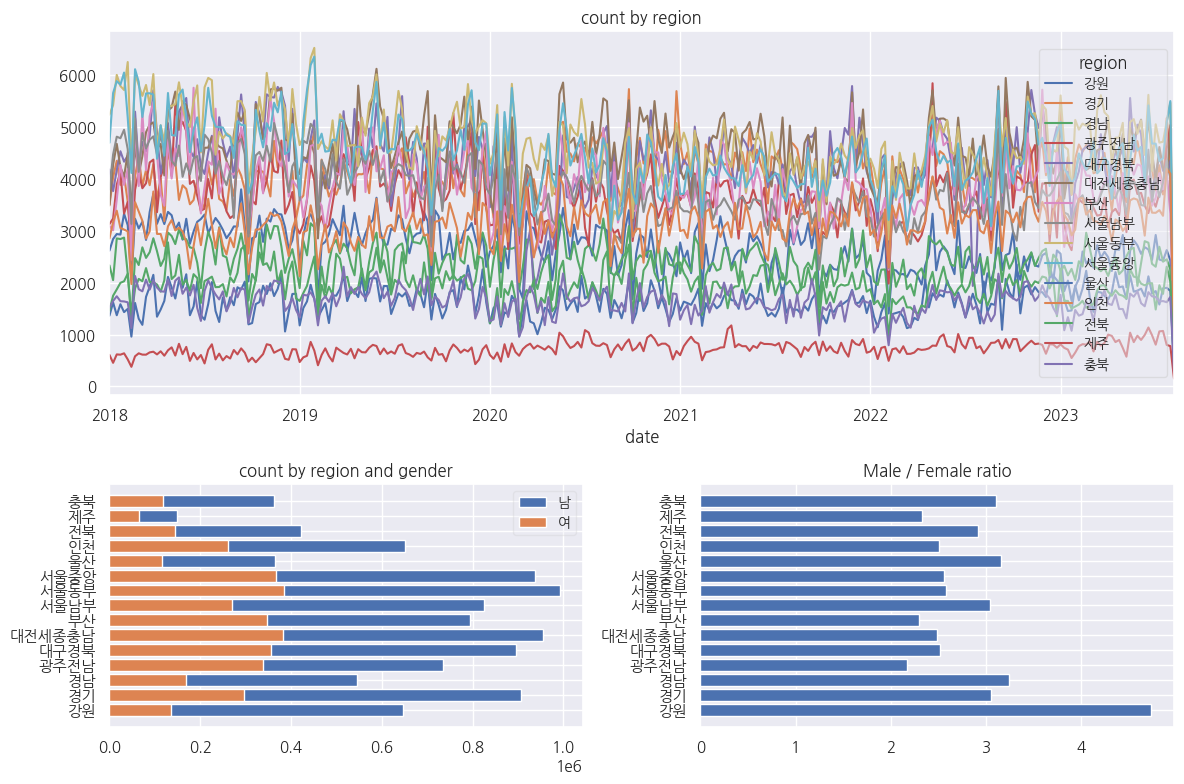

In [18]:
# Differences between regions
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1.5, 1])

ax = fig.add_subplot(gs[0, :])
bd_group = daily_bd_df.groupby(by=["date", "region"])["count"].sum().unstack().resample('W').sum()
bd_group.plot.line(title="count by region", ax=ax)
ax.legend(title='region', loc=5, fontsize=10, framealpha=0.5)

ax = fig.add_subplot(gs[1, 0])
bd_group = daily_bd_df.groupby(by=["region", "gender"])["count"].sum().unstack()
ax.barh(bd_group["남"].index, bd_group["남"], label="남")
ax.barh(bd_group["여"].index, bd_group["여"], label="여")
ax.set_title("count by region and gender")
ax.legend(loc=1, fontsize=10, framealpha=0.3)

ax = fig.add_subplot(gs[1, 1])
ax.barh(bd_group.index, (bd_group["남"].values / bd_group["여"].values))
ax.set_title("Male / Female ratio")

plt.tight_layout()
plt.show()

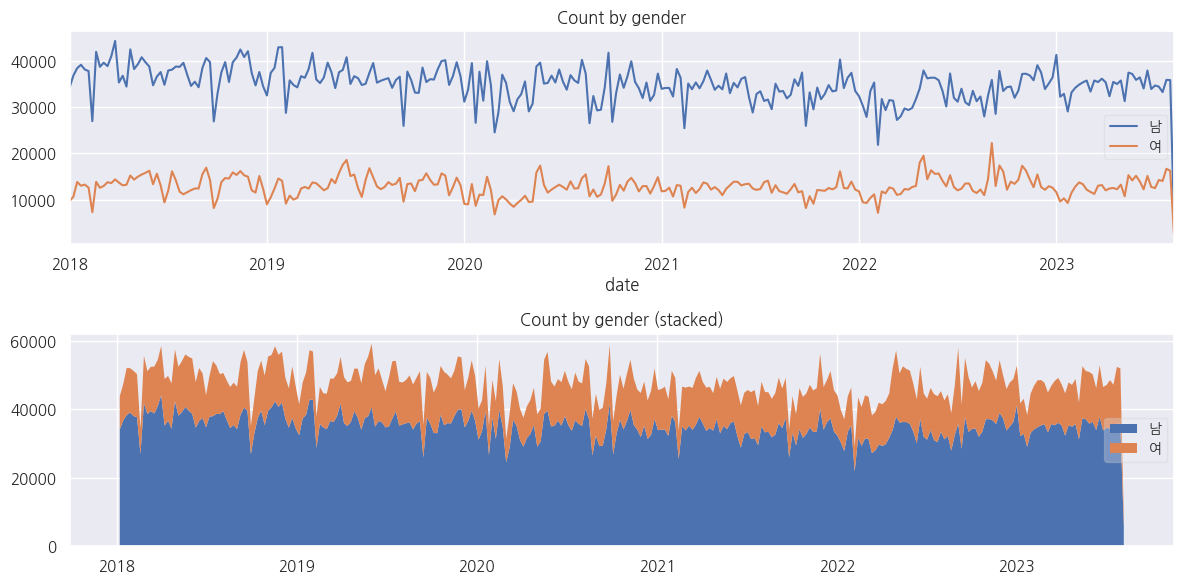

In [19]:
# Differences between genders
_, axs = plt.subplots(2, 1, figsize=(12, 6))

bd_gender_group = daily_bd_df.groupby(by=["date", "gender"])["count"].sum().unstack().resample('W').sum()
bd_gender_group.plot.line(title="Count by gender", ax=axs[0])

axs[1].stackplot(bd_gender_group.index, bd_gender_group["남"], bd_gender_group["여"], labels=["남", "여"], edgecolor="none")
axs[1].set_title("Count by gender (stacked)")

for ax in axs:
    ax.legend(loc=5, fontsize=10, framealpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Missing dates by regions
promo_start_date = '2021-01-01'
promo_end_date = '2023-07-31'
promo_complete_date_range = pd.date_range(start=promo_start_date, end=promo_end_date, freq='D')

region_missing_dates_dict = dict()  # 지역별 missing dates

daily_bd_promo_df.groupby(by=["region", "date"])["count"].sum()

for region in daily_bd_promo_df["region"].unique():
    region_missing_dates_dict[region] = pd.Series(index=promo_complete_date_range, data=0, name="missing")

    day_off_series = ~promo_complete_date_range.isin(daily_bd_promo_df[daily_bd_promo_df["region"] == region]["date"])
    missing_dates = promo_complete_date_range[day_off_series]
    region_missing_dates_dict[region][day_off_series] = 1
    print(f"the number of missing dates in {region}: {len(missing_dates)}")
    print(missing_dates)

bd_group = daily_bd_df.groupby(by=["date", "method"])["count"].sum().unstack()
bd_group = bd_group["전혈 400ml"]

for year in bd_group.index.year.unique():
    print(f"{year}: {len(bd_group[bd_group.index.year == year])}")

start_date = '2018-01-01'
end_date = '2023-07-31'

complete_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
day_off_series = ~complete_date_range.isin(bd_group.index.values)
missing_dates = complete_date_range[day_off_series]

print(f"the number of missing dates: {len(missing_dates)}")
print(missing_dates)

bd_group = bd_group.reindex(complete_date_range).fillna(0)

the number of missing dates in 강원: 13
DatetimeIndex(['2021-01-01', '2021-02-11', '2021-02-12', '2021-05-05',
               '2021-09-20', '2021-09-21', '2022-01-31', '2022-02-01',
               '2022-09-09', '2022-09-10', '2023-01-21', '2023-01-22',
               '2023-01-23'],
              dtype='datetime64[ns]', freq=None)
the number of missing dates in 경기: 28
DatetimeIndex(['2021-01-01', '2021-02-11', '2021-02-12', '2021-05-05',
               '2021-08-16', '2021-09-20', '2021-09-21', '2021-10-04',
               '2021-10-27', '2021-12-25', '2022-01-01', '2022-01-31',
               '2022-02-01', '2022-03-29', '2022-06-01', '2022-06-29',
               '2022-09-09', '2022-09-10', '2022-09-29', '2022-11-10',
               '2022-12-25', '2023-01-01', '2023-01-21', '2023-01-22',
               '2023-04-04', '2023-04-27', '2023-05-05', '2023-06-29'],
              dtype='datetime64[ns]', freq=None)
the number of missing dates in 경남: 22
DatetimeIndex(['2021-01-01', '2021-02-12', '202

## Get holiday data

In [21]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)

dow = bd_group.index.dayofweek  # 0: mon
dow_oh = ohe.fit_transform(np.expand_dims(dow, axis=1))

missing_dates = np.expand_dims(day_off_series.astype(int), axis=1)

key = '8LJ0fP6UFrv%2F0uLy5XGeK5GO%2ByGCpSUcdT9cv2p%2F1ri88wtDYJI0WYFMg4WOfaJMGA0X8IRYWlEicQyn%2B6ZSkQ%3D%3D'

holiday_list = []
for year in tqdm(range(2018, 2024)):
    url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo?' \
          '_type=json&numOfRows=50&' \
          'solYear=' + str(year) + '&ServiceKey=' + str(key)
    response = requests.get(url)
    if response.status_code == 200:
        holiday_list += response.json()["response"]["body"]["items"]["item"]

holiday_index = pd.Series([str(date["locdate"]) for date in holiday_list], dtype="datetime64[ns]")
holiday_sereis = pd.Series(1, index=holiday_index, dtype="int")
holiday_sereis = holiday_sereis.reindex(bd_group.index).fillna(0)
holiday = np.expand_dims(holiday_sereis, axis=1)

100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


In [22]:
# dow/holiday dummies for promotion period
promo_holiday_sereis = holiday_sereis[promo_start_date: promo_end_date]
promo_dow_oh = ohe.fit_transform(np.expand_dims(promo_complete_date_range.dayofweek, axis=1))

promo_dow_holiday_df = pd.DataFrame(
    np.concatenate([promo_dow_oh, np.expand_dims(promo_holiday_sereis, axis=1)], axis=1),
    columns=["mon", "tue", "wed", "thu", "fri", "sat", "sun", "holiday"],
    index=promo_complete_date_range)
display(promo_dow_holiday_df)

,mon,tue,wed,thu,fri,sat,sun,holiday
2021-01-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2021-01-02,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2021-01-03,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2021-01-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-07-27,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2023-07-28,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2023-07-29,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2023-07-30,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Analysis

## Promotion effect

In [23]:
# 일반 프로모션 (연)

# 남/여 비교
region_list = ["강원", "경남", "광주전남", "대구경북", "대전세종충남", "부산", "울산", "전북", "제주", "충북"]

region_promo_dict_list = []

for region in tqdm(region_list):
    region_promo_groupby = daily_bd_promo_df[(daily_bd_promo_df["region"] == region) & (
                (daily_bd_promo_df["method"] == "전혈 320ml") | (daily_bd_promo_df["method"] == "전혈 400ml"))].groupby(
        by=["date", "gender"]).agg({"count": "sum", "promotion": "sum"}).reset_index()

    region_promo_groupby["promotion"] = region_promo_groupby["promotion"].apply(lambda row: min(1, row))

    for gender in ["남", "여"]:
        for year in range(2021, 2023 + 1):
            region_promo_temp = region_promo_groupby[region_promo_groupby["gender"] == gender]

            region_promo_y = pd.Series(data=region_promo_temp["count"].values, index=region_promo_temp["date"]) \
                .reindex(promo_complete_date_range).fillna(0)

            region_promo = pd.Series(data=region_promo_temp["promotion"].values, index=region_promo_temp["date"],
                                     name="promotion") \
                .reindex(promo_complete_date_range).fillna(0)

            region_promo_X = pd.concat([promo_dow_holiday_df, region_missing_dates_dict[region], region_promo], axis=1)

            region_promo_y = region_promo_y.loc[f"{year}":f"{year}"]
            region_promo_X = region_promo_X.loc[f"{year}":f"{year}"]

            region_promo_model = sm.OLS(region_promo_y, region_promo_X).fit()
            # print(region_promo_model.summary())
            weekday_mean = np.mean(region_promo_model.params.values[:5])
            promo_effect = region_promo_model.params.values[9] / weekday_mean
            region_promo_dict_list.append({
                "region": region,
                "gender": gender,
                "coef": promo_effect,
                "p_val": region_promo_model.pvalues[9],
                "year": f"{year}",
                "promo_ratio": np.mean(region_promo_X["promotion"]),
                "dates_count": len(region_promo_X)
            })

region_promo_df = pd.DataFrame(region_promo_dict_list)
region_promo_df.to_csv("./output/promo_region_gender_year.csv", encoding="utf8", index=False)
display(region_promo_df)

100%|██████████| 10/10 [00:00<00:00, 31.10it/s]


,region,gender,coef,p_val,year,promo_ratio,dates_count
0,강원,남,0.151596,3.726438e-07,2021,0.498630,365
1,강원,남,0.082868,2.870228e-03,2022,0.380822,365
2,강원,남,0.139171,2.397584e-04,2023,0.603774,212
3,강원,여,0.131811,2.061518e-04,2021,0.498630,365
4,강원,여,-0.042754,4.086886e-01,2022,0.380822,365
5,강원,여,0.094218,8.666586e-02,2023,0.603774,212
6,경남,남,0.161824,3.576572e-07,2021,0.479452,365
7,경남,남,-0.022176,5.003893e-01,2022,0.326027,365
8,경남,남,0.010570,8.177795e-01,2023,0.169811,212
9,경남,여,0.058350,9.639519e-02,2021,0.479452,365


In [24]:
# 일반 프로모션 (분기)

# 남/여 비교
region_list = ["강원", "경남", "광주전남", "대구경북", "대전세종충남", "부산", "울산", "전북", "제주", "충북"]

quarter_dates = [
    ("1-1", "3-31"),
    ("4-1", "6-30"),
    ("7-1", "9-30"),
    ("10-1", "12-31")
]

region_promo_dict_list = []

for region in tqdm(region_list):
    region_promo_groupby = daily_bd_promo_df[(daily_bd_promo_df["region"] == region) & (
                (daily_bd_promo_df["method"] == "전혈 320ml") | (daily_bd_promo_df["method"] == "전혈 400ml"))].groupby(
        by=["date", "gender"]).agg({"count": "sum", "promotion": "sum"}).reset_index()

    region_promo_groupby["promotion"] = region_promo_groupby["promotion"].apply(lambda row: min(1, row))

    for gender in ["남", "여"]:
        for year in range(2021, 2023 + 1):
            for (quarter, (quarter_start, quarter_end)) in enumerate(quarter_dates, start=1):
                if year == 2023 and quarter > 2:
                    continue
                # print(f"{year}Q{quarter}", f"{year}-{quarter_start}", f"{year}-{quarter_end}")

                region_promo_temp = region_promo_groupby[region_promo_groupby["gender"] == gender]

                region_promo_y = pd.Series(data=region_promo_temp["count"].values, index=region_promo_temp["date"]) \
                    .reindex(promo_complete_date_range).fillna(0)

                region_promo = pd.Series(data=region_promo_temp["promotion"].values, index=region_promo_temp["date"],
                                         name="promotion") \
                    .reindex(promo_complete_date_range).fillna(0)

                region_promo_X = pd.concat([promo_dow_holiday_df, region_missing_dates_dict[region], region_promo],
                                           axis=1)

                region_promo_y = region_promo_y.loc[f"{year}-{quarter_start}":f"{year}-{quarter_end}"]
                region_promo_X = region_promo_X.loc[f"{year}-{quarter_start}":f"{year}-{quarter_end}"]

                region_promo_model = sm.OLS(region_promo_y, region_promo_X).fit()
                # print(region_promo_model.summary())
                weekday_mean = np.mean(region_promo_model.params.values[:5])
                promo_effect = region_promo_model.params.values[9] / weekday_mean
                region_promo_dict_list.append({
                    "region": region,
                    "gender": gender,
                    "coef": promo_effect,
                    "p_val": region_promo_model.pvalues[9],
                    "year": year,
                    "quarter": quarter,
                    "promo_ratio": np.mean(region_promo_X["promotion"])
                })

region_promo_df = pd.DataFrame(region_promo_dict_list)
region_promo_df.to_csv("./output/promo_region_gender_quarter.csv", encoding="utf8", index=False)
display(region_promo_df)

100%|██████████| 10/10 [00:00<00:00, 12.38it/s]


,region,gender,coef,p_val,year,quarter,promo_ratio
0,강원,남,0.202985,0.000213,2021,1,0.622222
1,강원,남,0.141405,0.008620,2021,2,0.439560
2,강원,남,0.166101,0.024683,2021,3,0.510870
3,강원,남,0.038955,0.495470,2021,4,0.423913
4,강원,남,0.408304,0.000160,2022,1,0.833333
...,...,...,...,...,...,...,...
195,충북,여,0.110054,0.177842,2022,2,0.439560
196,충북,여,-0.002280,0.987592,2022,3,0.195652
197,충북,여,0.044669,0.721269,2022,4,0.130435
198,충북,여,-0.000430,0.995247,2023,1,0.400000


In [25]:
# 수도권 외 지역 특수 프로모션 효과 확인

# period_start ~ period_end (프로모션 기간) vs 기간 앞뒤 2주 비교
region_special_promo_dict_list = []

region_list = ["강원", "경남", "광주전남", "대구경북", "대전세종충남", "부산", "울산", "전북", "제주", "충북"]

for region in tqdm(region_list):
    region_special_promo = special_promotions_df[special_promotions_df["institution"] == region]
    region_special_promo = region_special_promo[region_special_promo["period_days"] < 100]

    for _, row in region_special_promo.iterrows():
        # special promo dates dummy
        special_promo_dates = pd.Series(index=promo_complete_date_range, data=0, name="special_promo")
        special_promo_dates.loc[row["period_start"]:row["period_end"]] = 1

        # special promo control dates dummy
        special_promo_control_dates = pd.Series(index=promo_complete_date_range, data=0, name="special_promo_control")
        control_start = max(row['period_start'] - timedelta(days=14), datetime(2021, 1, 1))
        control_end = min(row['period_end'] + timedelta(days=14), datetime(2023, 7, 31))
        special_promo_control_dates.loc[control_start:row["period_start"] - timedelta(days=1)] = 1
        special_promo_control_dates.loc[row["period_end"] + timedelta(days=1):control_end] = 1

        # print(f"promo_period: {row['period_start'].strftime('%Y-%m-%d')} ~ {row['period_end'].strftime('%Y-%m-%d')}")
        # print(f"control_period: {control_start.strftime('%Y-%m-%d')} ~ {(row['period_start']-timedelta(days=1)).strftime('%Y-%m-%d')} & {(row['period_end']+timedelta(days=1)).strftime('%Y-%m-%d')} ~ {control_end.strftime('%Y-%m-%d')}")

        region_promo_groupby = daily_bd_promo_df[(daily_bd_promo_df["region"] == region) & (
                    (daily_bd_promo_df["method"] == "전혈 320ml") | (daily_bd_promo_df["method"] == "전혈 400ml"))].groupby(
            by=["date", "gender"]).agg({"count": "sum", "promotion": "sum"}).reset_index()

        for gender in ["남", "여"]:
            region_promo_groupby["promotion"] = region_promo_groupby["promotion"].apply(lambda row: min(1, row))

            region_promo_temp = region_promo_groupby[region_promo_groupby["gender"] == gender]

            region_promo_y = pd.Series(data=region_promo_temp["count"].values, index=region_promo_temp["date"]) \
                .reindex(promo_complete_date_range).fillna(0)

            region_promo = pd.Series(data=region_promo_temp["promotion"].values, index=region_promo_temp["date"],
                                     name="promotion") \
                .reindex(promo_complete_date_range).fillna(0)

            region_promo_X = pd.concat(
                [promo_dow_holiday_df, region_missing_dates_dict[region], region_promo, special_promo_dates,
                 special_promo_control_dates], axis=1)

            region_promo_model = sm.OLS(region_promo_y, region_promo_X).fit()
            # print(region_promo_model.summary())

            weekday_mean = np.mean(region_promo_model.params.values[:5])
            promo_effect = region_promo_model.params.values[9] / weekday_mean
            special_promo_effect = region_promo_model.params.values[10] / weekday_mean
            special_promo_control_effect = region_promo_model.params.values[11] / weekday_mean

            region_special_promo_dict_list.append({
                "promo_name": row["title"],
                "promo_url": row["url"],
                "promo_hits": row["hits"],
                "region": region,
                "gender": gender,
                "special_promo_coef": special_promo_effect,
                "special_promo_p_val": region_promo_model.pvalues[10],
                "special_promo_control_coef": special_promo_control_effect,
                "special_promo_control_p_val": region_promo_model.pvalues[11],
                "special_promo_dates": sum(special_promo_dates),
                "special_promo_control_dates": sum(special_promo_control_dates)
            })

region_special_promo_df = pd.DataFrame(region_special_promo_dict_list)
region_special_promo_df.to_csv("./output/region_special_promo.csv", encoding="utf8", index=False)
display(region_special_promo_df)

100%|██████████| 10/10 [00:01<00:00,  9.27it/s]


,promo_name,promo_url,promo_hits,region,gender,special_promo_coef,special_promo_p_val,special_promo_control_coef,special_promo_control_p_val,special_promo_dates,special_promo_control_dates
0,[강원혈액원] 강원대학교와 함께하는 1004 캠페인,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2181,강원,남,0.024225,6.237946e-01,-0.019455,7.110443e-01,33,28
1,[강원혈액원] 강원대학교와 함께하는 1004 캠페인,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2181,강원,여,0.110676,1.487183e-01,0.040423,6.197067e-01,33,28
2,레드커넥트 예약헌혈 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,20742,강원,남,-0.030501,3.271717e-01,-0.054994,2.919899e-01,92,28
3,레드커넥트 예약헌혈 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,20742,강원,여,0.006370,8.958027e-01,-0.011863,8.843247e-01,92,28
4,헌혈하고? 문화행사 즐기자!,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,16838,강원,남,-0.020024,5.570893e-01,-0.095896,6.724600e-02,70,28
...,...,...,...,...,...,...,...,...,...,...,...
129,헌혈자의 날(6.14) 기념행사 및 영화 관람,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,14284,충북,여,0.302078,5.754529e-04,0.209019,8.866402e-03,23,28
130,헌혈하고 대청호로 드라이브 갈까,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,7215,충북,남,0.101424,1.046060e-01,0.002650,9.634842e-01,24,28
131,헌혈하고 대청호로 드라이브 갈까,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,7215,충북,여,0.410395,9.208744e-07,0.433057,2.463413e-08,24,28
132,2021년 충북혈액원 중장년층대상 문화이벤트,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,7525,충북,남,0.012335,8.278761e-01,-0.067841,2.408291e-01,29,28


In [26]:
# 수도권 지역 특수 프로모션 효과 확인
# period_start ~ period_end (프로모션 기간) vs 기간 앞뒤 2주 비교
region_special_promo_dict_list = []

metro_region_list = ["경기", "서울남부", "서울동부", "서울중앙", "인천"]

for region in tqdm(metro_region_list):
    region_special_promo = special_promotions_df[special_promotions_df["institution"] == region]
    region_special_promo = region_special_promo[region_special_promo["period_days"] < 100]

    for _, row in region_special_promo.iterrows():
        # special promo dates dummy
        special_promo_dates = pd.Series(index=promo_complete_date_range, data=0, name="special_promo")
        special_promo_dates.loc[row["period_start"]:row["period_end"]] = 1

        # special promo control dates dummy
        special_promo_control_dates = pd.Series(index=promo_complete_date_range, data=0, name="special_promo_control")
        control_start = max(row['period_start'] - timedelta(days=14), datetime(2021, 1, 1))
        control_end = min(row['period_end'] + timedelta(days=14), datetime(2023, 7, 31))
        special_promo_control_dates.loc[control_start:row["period_start"] - timedelta(days=1)] = 1
        special_promo_control_dates.loc[row["period_end"] + timedelta(days=1):control_end] = 1

        # print(f"promo_period: {row['period_start'].strftime('%Y-%m-%d')} ~ {row['period_end'].strftime('%Y-%m-%d')}")
        # print(f"control_period: {control_start.strftime('%Y-%m-%d')} ~ {(row['period_start']-timedelta(days=1)).strftime('%Y-%m-%d')} & {(row['period_end']+timedelta(days=1)).strftime('%Y-%m-%d')} ~ {control_end.strftime('%Y-%m-%d')}")

        region_promo_groupby = daily_bd_promo_df[(daily_bd_promo_df["region"] == region) & (
                    (daily_bd_promo_df["method"] == "전혈 320ml") | (daily_bd_promo_df["method"] == "전혈 400ml"))].groupby(
            by=["date", "gender"]).agg({"count": "sum", "promotion": "sum"}).reset_index()

        for gender in ["남", "여"]:
            region_promo_groupby["promotion"] = region_promo_groupby["promotion"].apply(lambda row: min(1, row))

            region_promo_temp = region_promo_groupby[region_promo_groupby["gender"] == gender]

            region_promo_y = pd.Series(data=region_promo_temp["count"].values, index=region_promo_temp["date"]) \
                .reindex(promo_complete_date_range).fillna(0)

            # region_promo = pd.Series(data=region_promo_temp["promotion"].values, index=region_promo_temp["date"], name="promotion")\
            #     .reindex(promo_complete_date_range).fillna(0)

            region_promo_X = pd.concat([promo_dow_holiday_df, region_missing_dates_dict[region], special_promo_dates,
                                        special_promo_control_dates], axis=1)

            region_promo_model = sm.OLS(region_promo_y, region_promo_X).fit()
            # print(region_promo_model.summary())

            weekday_mean = np.mean(region_promo_model.params.values[:5])
            special_promo_effect = region_promo_model.params.values[9] / weekday_mean
            special_promo_control_effect = region_promo_model.params.values[10] / weekday_mean

            region_special_promo_dict_list.append({
                "promo_name": row["title"],
                "promo_url": row["url"],
                "promo_hits": row["hits"],
                "region": region,
                "gender": gender,
                "special_promo_coef": special_promo_effect,
                "special_promo_p_val": region_promo_model.pvalues[9],
                "special_promo_control_coef": special_promo_control_effect,
                "special_promo_control_p_val": region_promo_model.pvalues[10],
                "special_promo_dates": sum(special_promo_dates),
                "special_promo_control_dates": sum(special_promo_control_dates)
            })

region_special_promo_df = pd.DataFrame(region_special_promo_dict_list)
region_special_promo_df.to_csv("./output/region_special_promo_metro.csv", encoding="utf8", index=False)
display(region_special_promo_df)

100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


,promo_name,promo_url,promo_hits,region,gender,special_promo_coef,special_promo_p_val,special_promo_control_coef,special_promo_control_p_val,special_promo_dates,special_promo_control_dates
0,(경기혈액원)6.14헌혈자의 날 기념 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,3928,경기,남,0.073857,0.449284,-0.049739,0.182742,4,28
1,(경기혈액원)6.14헌혈자의 날 기념 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,3928,경기,여,0.091748,0.437380,-0.139959,0.001992,4,28
2,[경기혈액원] 2023년 헌혈자의 날(6.14)기념 헌혈자 초청 프로모션( KT위즈...,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,12354,경기,남,0.087527,0.076625,-0.039847,0.286210,16,28
3,[경기혈액원] 2023년 헌혈자의 날(6.14)기념 헌혈자 초청 프로모션( KT위즈...,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,12354,경기,여,0.017848,0.766132,-0.094865,0.036790,16,28
4,경기혈액원 중장년 문화행사 서울스카이 겨울풀코스,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,15754,경기,남,-0.012584,0.645295,0.038080,0.310279,54,28
...,...,...,...,...,...,...,...,...,...,...,...
135,[인천혈액원] 성년의날 기념 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,1495,인천,여,0.474436,0.083243,-0.011423,0.827495,1,28
136,[인천혈액원] 10대 헌혈 응원 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2713,인천,남,0.058413,0.207398,0.025674,0.542666,23,28
137,[인천혈액원] 10대 헌혈 응원 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,2713,인천,여,0.039399,0.494793,-0.021836,0.677713,23,28
138,인천혈액원 중장년층 문화행사,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,8927,인천,남,0.078978,0.060418,-0.044493,0.289020,28,28


In [27]:
# 전국 특별 프로모션

region_special_promo_dict_list = []

region_list_dict = {
    "non_metro": region_list,
    "metro": metro_region_list
}

region_special_promo = special_promotions_df[special_promotions_df["institution"] == "혈액관리본부"]
region_special_promo = region_special_promo[region_special_promo["period_days"] < 100]

for _, row in tqdm(region_special_promo.iterrows()):
    # special promo dates dummy
    special_promo_dates = pd.Series(index=promo_complete_date_range, data=0, name="special_promo")
    special_promo_dates.loc[row["period_start"]:row["period_end"]] = 1

    # special promo control dates dummy
    special_promo_control_dates = pd.Series(index=promo_complete_date_range, data=0, name="special_promo_control")
    control_start = max(row['period_start'] - timedelta(days=14), datetime(2021, 1, 1))
    control_end = min(row['period_end'] + timedelta(days=14), datetime(2023, 7, 31))
    special_promo_control_dates.loc[control_start:row["period_start"] - timedelta(days=1)] = 1
    special_promo_control_dates.loc[row["period_end"] + timedelta(days=1):control_end] = 1

    for region_cat, region_list_temp in region_list_dict.items():
        for region in region_list_temp:
            region_promo_groupby = daily_bd_promo_df[(daily_bd_promo_df["region"] == region) & (
                        (daily_bd_promo_df["method"] == "전혈 320ml") | (
                            daily_bd_promo_df["method"] == "전혈 400ml"))].groupby(by=["date", "gender"]).agg(
                {"count": "sum", "promotion": "sum"}).reset_index()

            for gender in ["남", "여"]:
                region_promo_groupby["promotion"] = region_promo_groupby["promotion"].apply(lambda row: min(1, row))

                region_promo_temp = region_promo_groupby[region_promo_groupby["gender"] == gender]

                region_promo_y = pd.Series(data=region_promo_temp["count"].values, index=region_promo_temp["date"]) \
                    .reindex(promo_complete_date_range).fillna(0)

                if region_cat == "non_metro":
                    region_promo = pd.Series(data=region_promo_temp["promotion"].values,
                                             index=region_promo_temp["date"], name="promotion") \
                        .reindex(promo_complete_date_range).fillna(0)

                    concat_list = [promo_dow_holiday_df, region_missing_dates_dict[region], region_promo,
                                   special_promo_dates, special_promo_control_dates]
                else:
                    concat_list = [promo_dow_holiday_df, region_missing_dates_dict[region], special_promo_dates,
                                   special_promo_control_dates]

                region_promo_X = pd.concat(concat_list, axis=1)

                region_promo_model = sm.OLS(region_promo_y, region_promo_X).fit()
                # print(region_promo_model.summary())

                weekday_mean = np.mean(region_promo_model.params.values[:5])
                special_promo_effect = region_promo_model.params.values[-2] / weekday_mean
                special_promo_control_effect = region_promo_model.params.values[-1] / weekday_mean

                region_special_promo_dict_list.append({
                    "promo_name": row["title"],
                    "promo_url": row["url"],
                    "promo_hits": row["hits"],
                    "region": region,
                    "gender": gender,
                    "special_promo_coef": special_promo_effect,
                    "special_promo_p_val": region_promo_model.pvalues[-2],
                    "special_promo_control_coef": special_promo_control_effect,
                    "special_promo_control_p_val": region_promo_model.pvalues[-1],
                    "special_promo_dates": sum(special_promo_dates),
                    "special_promo_control_dates": sum(special_promo_control_dates)
                })

region_special_promo_df = pd.DataFrame(region_special_promo_dict_list)
region_special_promo_df.to_csv("./output/region_special_promo_country.csv", encoding="utf8", index=False)
display(region_special_promo_df)

104it [00:22,  4.55it/s]


,promo_name,promo_url,promo_hits,region,gender,special_promo_coef,special_promo_p_val,special_promo_control_coef,special_promo_control_p_val,special_promo_dates,special_promo_control_dates
0,ABO Friends 대상 6월 라섹 수술이벤트,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,8129,강원,남,0.024785,0.674631,-0.081618,0.126265,22,28
1,ABO Friends 대상 6월 라섹 수술이벤트,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,8129,강원,여,-0.018631,0.838328,0.139315,0.091578,22,28
2,ABO Friends 대상 6월 라섹 수술이벤트,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,8129,경남,남,0.005450,0.929416,0.041502,0.446764,22,28
3,ABO Friends 대상 6월 라섹 수술이벤트,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,8129,경남,여,-0.059226,0.442128,0.086612,0.204891,22,28
4,ABO Friends 대상 6월 라섹 수술이벤트,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,8129,광주전남,남,-0.038545,0.448053,-0.017637,0.694660,22,28
...,...,...,...,...,...,...,...,...,...,...,...
3115,넥센타이어와 함께하는 봄맞이 생명안전 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,35326,서울동부,여,-0.095464,0.010938,-0.058888,0.277808,61,28
3116,넥센타이어와 함께하는 봄맞이 생명안전 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,35326,서울중앙,남,-0.011814,0.694856,0.033508,0.442546,61,28
3117,넥센타이어와 함께하는 봄맞이 생명안전 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,35326,서울중앙,여,-0.105199,0.004779,0.068805,0.201958,61,28
3118,넥센타이어와 함께하는 봄맞이 생명안전 프로모션,https://www.bloodinfo.net/knrcbs/pr/promtn/pro...,35326,인천,남,-0.011346,0.694480,-0.070072,0.094334,61,28


In [28]:
# 혈소판 성분헌혈
region_list = ["강원", "경남", "광주전남", "대구경북", "대전세종충남", "부산", "울산", "전북", "제주", "충북"]
platelet_promo_effectiveness = []

region_promo_groupby = daily_bd_promo_df[
    (daily_bd_promo_df["method"] == "다종성분") | (daily_bd_promo_df["method"] == "혈소판")].groupby(
    by=["date", "region"]).agg({"count": "sum", "promotion": "sum"}).reset_index()

region_promo_groupby["promotion"] = region_promo_groupby["promotion"].apply(lambda row: min(1, row))

for region in region_list:
    region_promo_temp = region_promo_groupby[region_promo_groupby["region"] == region]

    region_promo_y = pd.Series(data=region_promo_temp["count"].values, index=region_promo_temp["date"]) \
        .reindex(promo_complete_date_range).fillna(0)

    region_promo = pd.Series(data=region_promo_temp["promotion"].values, index=region_promo_temp["date"],
                             name="promotion") \
        .reindex(promo_complete_date_range).fillna(0)

    region_promo_X = pd.concat([promo_dow_holiday_df, region_missing_dates_dict[region], region_promo], axis=1)

    region_promo_model = sm.OLS(region_promo_y, region_promo_X).fit()
    # print(region_promo_model.summary())
    weekday_mean = np.mean(region_promo_model.params.values[:5])
    promo_effect = region_promo_model.params.values[9] / weekday_mean

    print(f"{region} effectiveness: {promo_effect:.1%}, pval: {region_promo_model.pvalues[9]:.2f}")
    platelet_promo_effectiveness.append(promo_effect)

강원 effectiveness: 5.4%, pval: 0.00
경남 effectiveness: 10.4%, pval: 0.00
광주전남 effectiveness: 6.8%, pval: 0.00
대구경북 effectiveness: 8.2%, pval: 0.00
대전세종충남 effectiveness: 1.9%, pval: 0.24
부산 effectiveness: 4.3%, pval: 0.00
울산 effectiveness: -2.1%, pval: 0.32
전북 effectiveness: 14.5%, pval: 0.00
제주 effectiveness: 5.2%, pval: 0.05
충북 effectiveness: 11.5%, pval: 0.00


## Blood donation

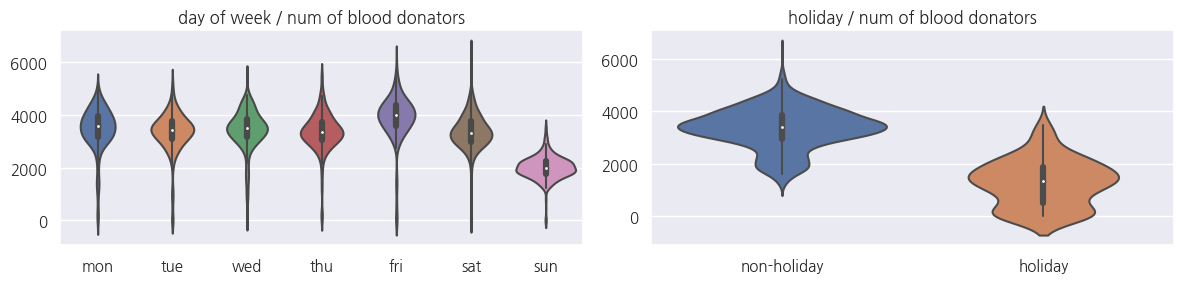

In [29]:
# Difference between dow/holiday distributions
_, axs = plt.subplots(1, 2, figsize=(12, 3))

sns.violinplot(x=dow.values, y=bd_group.values, ax=axs[0], fit_reg=False)
axs[0].set_title("day of week / num of blood donators")
axs[0].set_xticklabels(["mon", "tue", "wed", "thu", "fri", "sat", "sun"])

sns.violinplot(x=holiday_sereis.values, y=bd_group.values, ax=axs[1], fit_reg=False)
axs[1].set_title("holiday / num of blood donators")
axs[1].set_xticklabels(["non-holiday", "holiday"])

plt.tight_layout()
plt.show()

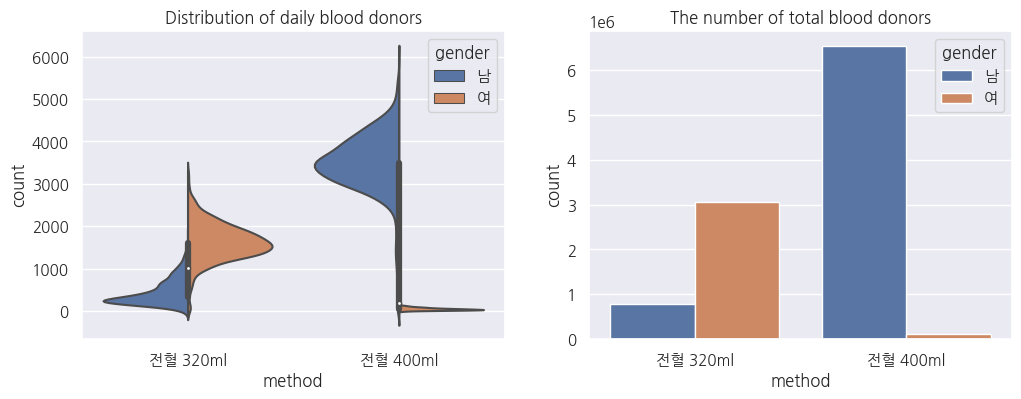

In [30]:
# Difference between bd methods
_, axs = plt.subplots(1, 2, figsize=(12, 4))

temp = daily_bd_df.groupby(by=["date", "gender", "method"])["count"].sum().reset_index()
temp = temp[temp["method"].isin(["전혈 400ml", "전혈 320ml"])]
temp["method"] = temp["method"].cat.remove_unused_categories()
temp = temp[temp["date"].dt.dayofweek < 5]
sns.violinplot(x="method", y="count", hue="gender", data=temp, ax=axs[0], scale="count", split=True)
axs[0].set_title("Distribution of daily blood donors")

temp = daily_bd_df.groupby(by=["gender", "method"])["count"].sum().reset_index()
temp = temp[temp["method"].isin(["전혈 400ml", "전혈 320ml"])]
temp["method"] = temp["method"].cat.remove_unused_categories()
sns.barplot(x="method", y="count", hue="gender", data=temp, ax=axs[1])
axs[1].set_title("The number of total blood donors")
plt.show()

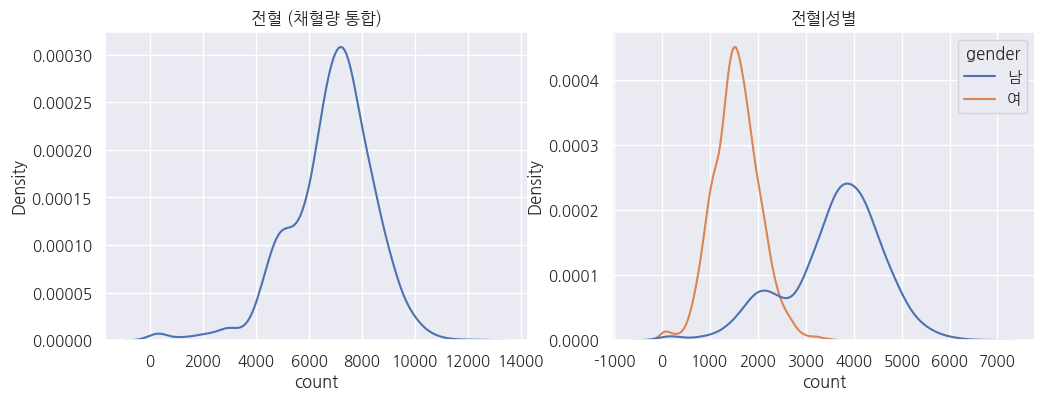

In [31]:
# gender effect
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

temp = daily_bd_df.groupby(by=["date"])["count"].sum().reset_index()
sns.kdeplot(x="count", data=temp, ax=axs[0])
axs[0].set_title("전혈 (채혈량 통합)")

temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])].groupby(by=["date", "gender"])[
    "count"].sum().reset_index()
sns.kdeplot(x="count", hue="gender", data=temp, ax=axs[1])
axs[1].set_title("전혈|성별")

plt.show()

Text(0.5, 1.0, '전혈|성별,요일')

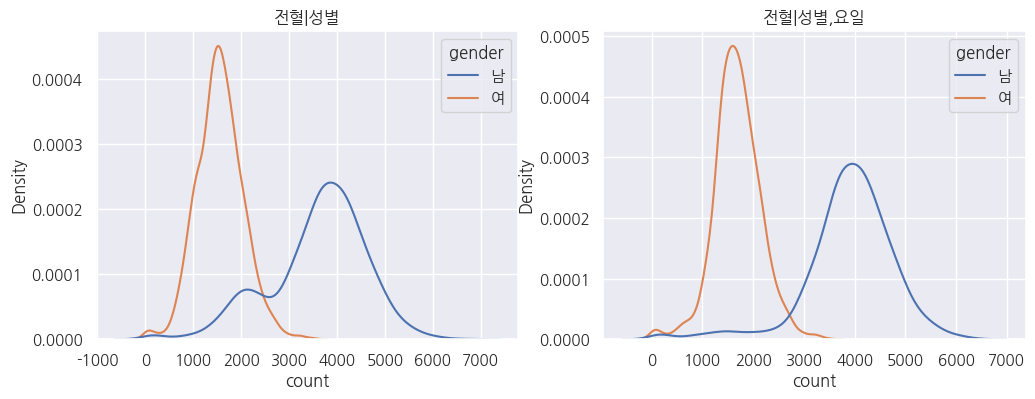

In [32]:
# dow effect
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])].groupby(by=["date", "gender"])[
    "count"].sum().reset_index()
sns.kdeplot(x="count", hue="gender", data=temp, ax=axs[0])
axs[0].set_title("전혈|성별")

temp = temp[temp["date"].dt.dayofweek < 5]  # 평일만
sns.kdeplot(x="count", hue="gender", data=temp, ax=axs[1])
axs[1].set_title("전혈|성별,요일")

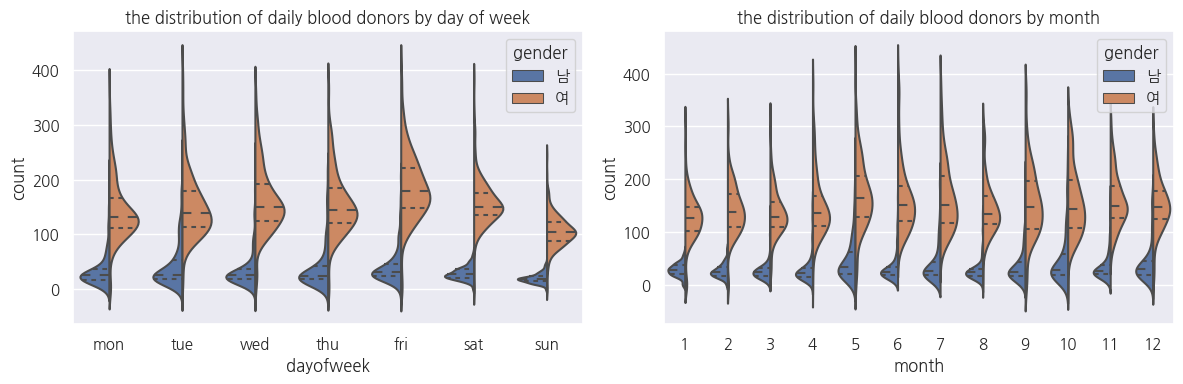

In [33]:
# difference in distribution between dow/month
from statsmodels.graphics.tsaplots import month_plot

bd_seoul_count_df = pd.DataFrame({"count": bd_group, "dayofweek": dow, "holiday": holiday_sereis})

_, axs = plt.subplots(1, 2, figsize=(12, 4))

temp = daily_bd_df.groupby(by=["date", "region", "gender", "method"])["count"].sum() \
    .xs("서울동부", level="region").xs("전혈 320ml", level="method").reset_index()
temp["dayofweek"] = temp["date"].dt.dayofweek
temp["month"] = temp["date"].dt.month
sns.violinplot(x="dayofweek", y="count", hue="gender", data=temp, scale="count", split=True, ax=axs[0],
               inner="quartile")
axs[0].set_xticklabels(["mon", "tue", "wed", "thu", "fri", "sat", "sun"])
axs[0].set_title("the distribution of daily blood donors by day of week")

sns.violinplot(x="month", y="count", hue="gender", data=temp, scale="count", split=True, ax=axs[1],
               inner="quartile")
axs[1].set_title("the distribution of daily blood donors by month")
# month_plot(x=bd_seoul_count_df["count"].values, dates=bd_seoul_count_df.index, ax=axs[1])

plt.tight_layout()
plt.show()

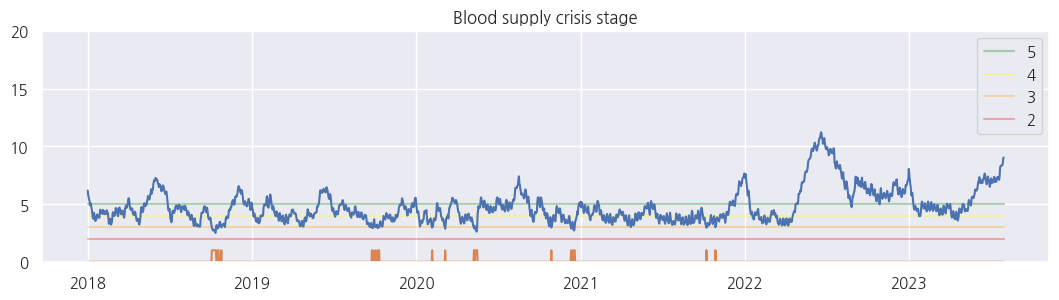

In [52]:
# blood shortage
bs_temp = daily_bs_df[(daily_bs_df["product"] == "적혈구")].groupby(by="date")["count"].sum()
bu_temp = np.sum(daily_bu_df, axis=1)
bd_temp = daily_bd_df[((daily_bd_df["method"] == "전혈 320ml") | (daily_bd_df["method"] == "전혈 400ml"))] \
    .groupby(by="date")["count"].sum().reindex(complete_date_range).fillna(0)

_, ax = plt.subplots(1, 1, figsize=(13, 3))

target_year = None

for i, c_name in zip(range(5, 1, -1), ["green", "yellow", "orange", "red"]):
    ax.plot([min(bs_temp.index), max(bs_temp.index)], [i, i], c=c_name, label=i, alpha=0.3)

blood_temp_df = pd.concat([bs_temp.rename("stock"), bu_temp.rename("usage")], axis=1)
blood_temp_df["dayofweek"] = blood_temp_df.index.dayofweek

year_usage_mean_df = blood_temp_df["usage"].groupby(lambda x: x.year).mean().to_dict()
previous_year_usage_mean_series = blood_temp_df.index.year.to_series().apply(
    lambda x: year_usage_mean_df[max(2018, x - 1)])
bd_crisis_status = blood_temp_df["stock"] / previous_year_usage_mean_series.values

# ax.plot(blood_temp_df["stock"] / blood_temp_df["usage"], label="stock/usage", alpha=0.5)
ax.plot(bd_crisis_status)
plt.plot(bd_crisis_status < 3)
if target_year:
    ax.set_xlim([date(target_year, 1, 1), date(target_year, 12, 31)])
ax.set_ylim([0, 20])
ax.legend()
ax.set_title("Blood supply crisis stage")
plt.show()

# Modeling

In [53]:
def draw_acf_pacf(data_dict: dict):
    _, axs = plt.subplots(len(data_dict), 3, figsize=(12, 3 * len(data_dict)))
    axs = axs.reshape((-1, 3))
    for ((key, data), ax_row) in zip(data_dict.items(), axs):
        ax_row[0].plot(data)
        ax_row[0].set_title(key)
        sgt.plot_acf(data, lags=40, zero=False, ax=ax_row[1])
        sgt.plot_pacf(data, lags=40, zero=False, ax=ax_row[2])
        ax_row[1].set_ylim([-0.5, 0.5])
        ax_row[2].set_ylim([-0.5, 0.5])
    plt.tight_layout()
    plt.show()


def make_fourier_terms(t, period, k):
    fourier_terms = []
    for i in range(1, k + 1):
        times = np.arange(t) + 1
        np.arange(k) + 1
        fourier_terms.append(np.sin(2 * i * np.pi * times / period))
        fourier_terms.append(np.cos(2 * i * np.pi * times / period))
    return np.array(fourier_terms).T

In [54]:
def arima_model(y_train, y_test, X_train, X_test, summary=False, plot=True, test_stats=True, arima_order=(1, 0, 3),
                target_year=2018):
    model = ARIMA(y_train, order=arima_order, seasonal_order=(1, 0, 1, 7), exog=X_train, trend="n")
    model.initialize_approximate_diffuse()
    model_fit = model.fit()

    if summary:
        print(model_fit.summary())

    if test_stats:
        print(f"AIC: {model_fit.aic}")

        y_train_predict = model_fit.predict().clip(lower=0)
        y_test_predict = model_fit.forecast(steps=len(y_test), exog=X_test).clip(lower=0)
        train_rmse = sm.tools.eval_measures.rmse(y_train, y_train_predict)
        test_rmse = sm.tools.eval_measures.rmse(y_test, y_test_predict)
        print(f"RMSE: {train_rmse}, {test_rmse}")

        ljung_box_p = np.squeeze(model_fit.test_serial_correlation(method="ljungbox", lags=[20]))[1]
        print(f"Ljung-Box p: {ljung_box_p}")

    if plot:
        _, axs = plt.subplots(2, 2, figsize=(12, 6))

        sgt.plot_acf(model_fit.resid, lags=40, zero=False, ax=axs[0][0])
        sgt.plot_pacf(model_fit.resid, lags=40, zero=False, ax=axs[0][1])
        for ax in axs[0]:
            ax.set_ylim([-0.15, 0.15])

        resid = model_fit.resid.values
        sns.histplot(np.concatenate([y_train, y_test]), kde=True, ax=axs[1][0], label="input")
        sns.histplot(resid, kde=True, ax=axs[1][0], label="resid")
        ax = axs[1][0].twinx()
        axs[1][0].legend()

        stats.probplot(resid, dist=stats.norm, plot=axs[1][1])

        plt.tight_layout()
        plt.show()

        _, ax = plt.subplots(1, 1, figsize=(12, 3))

        # plot prediction
        ax.plot(y_train, c="k")
        ax.plot(y_test, c="k")

        prediction = model_fit.get_prediction()
        predicted_mean = prediction.predicted_mean.clip(lower=0)

        ax.plot(predicted_mean)

        ci = prediction.conf_int(alpha=0.05)
        ax.fill_between(predicted_mean.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.1, color="C0")
        ci = prediction.conf_int(alpha=0.2)
        ax.fill_between(predicted_mean.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.3, color="C0")

        test_prediction = model_fit.get_forecast(steps=len(y_test), exog=X_test)
        test_predicted_mean = test_prediction.predicted_mean.clip(lower=0)

        ax.plot(test_predicted_mean)

        ci = test_prediction.conf_int(alpha=0.05)
        ax.fill_between(test_predicted_mean.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.1, color="C1")
        ci = test_prediction.conf_int(alpha=0.2)
        ax.fill_between(test_predicted_mean.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.3, color="C1")

        # ax.plot(holiday_sereis * max(y_train), alpha=0.3)  # holidays indicator
        # ax.plot(holiday_sereis.index, day_off_series.astype(int) * max(y_train))  # missing days indicator

        # ax.set_xlim([date(2018, 1, 1), date(2018, 4, 30)])
        ax.plot([min(predicted_mean.index), max(test_predicted_mean.index)], [0, 0], color="k", alpha=0.3)
        ax.set_xlim([date(target_year, 1, 1), date(target_year, 12, 31)])
        ax.set_ylim([min(y_train) - 1.5 * (np.std(y_train)), max(y_train) + 1.5 * (np.std(y_train))])
        plt.tight_layout()
        plt.show()
    return model_fit

## Blood donation

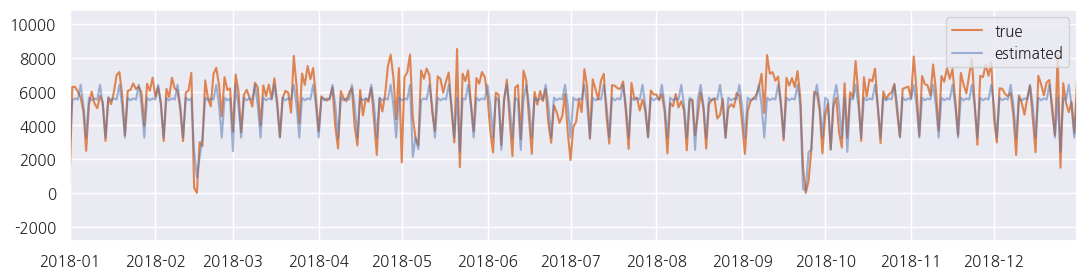

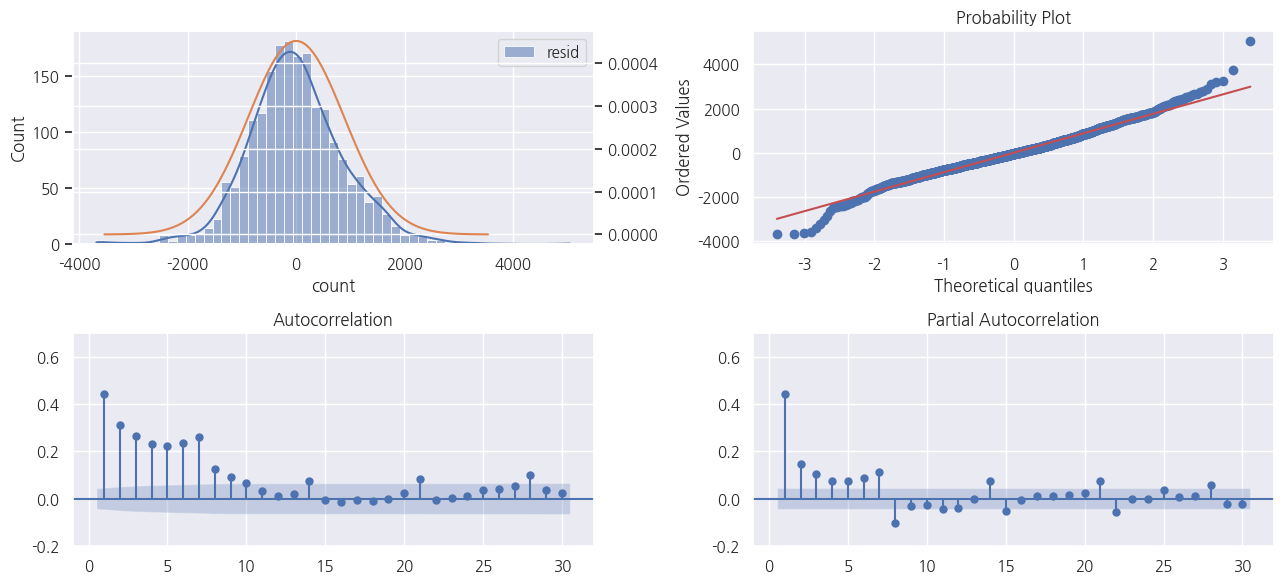

In [55]:
bd_temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])] \
    .groupby(by="date")["count"].sum().reindex(complete_date_range).fillna(0)
bd_exog_vars = np.concatenate([dow_oh, holiday, missing_dates], axis=1)
weekly_bd_model_fit = sm.OLS(bd_temp, bd_exog_vars).fit()

_, ax = plt.subplots(1, 1, figsize=(13, 3))

target_year = 2018

weekly_bd_y_predict = weekly_bd_model_fit.predict(bd_exog_vars)
weekly_bd_resid = bd_temp - weekly_bd_y_predict
ax.plot(bd_temp, color="C1", label="true")
ax.plot(bd_temp.index, weekly_bd_y_predict, color="C0", label="estimated", alpha=0.5)

if target_year:
    ax.set_xlim([date(target_year, 1, 1), date(target_year, 12, 31)])
ax.legend(loc=1)
plt.show()

_, axs = plt.subplots(2, 2, figsize=(13, 6))
sns.histplot(weekly_bd_resid, kde=True, ax=axs[0][0], label="resid")
ax = axs[0][0].twinx()
mu, std = stats.norm.fit(weekly_bd_resid)
x_range = np.linspace(mu - std * 4, mu + std * 4, 100)
ax.plot(x_range, stats.norm.pdf(x_range, mu, std), c="C1", label=f"N({int(mu)}, {int(std)}^2)")
axs[0][0].legend()

stats.probplot(weekly_bd_resid, dist=stats.norm, plot=axs[0][1])

sgt.plot_acf(weekly_bd_resid, lags=30, zero=False, ax=axs[1][0])
sgt.plot_pacf(weekly_bd_resid, lags=30, zero=False, ax=axs[1][1])
for ax in axs[1]:
    ax.set_ylim([-0.2, 0.7])

plt.tight_layout()
plt.show()

## Gender effect

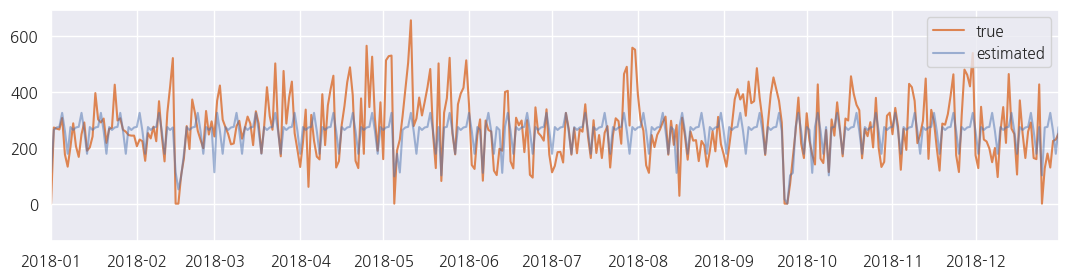

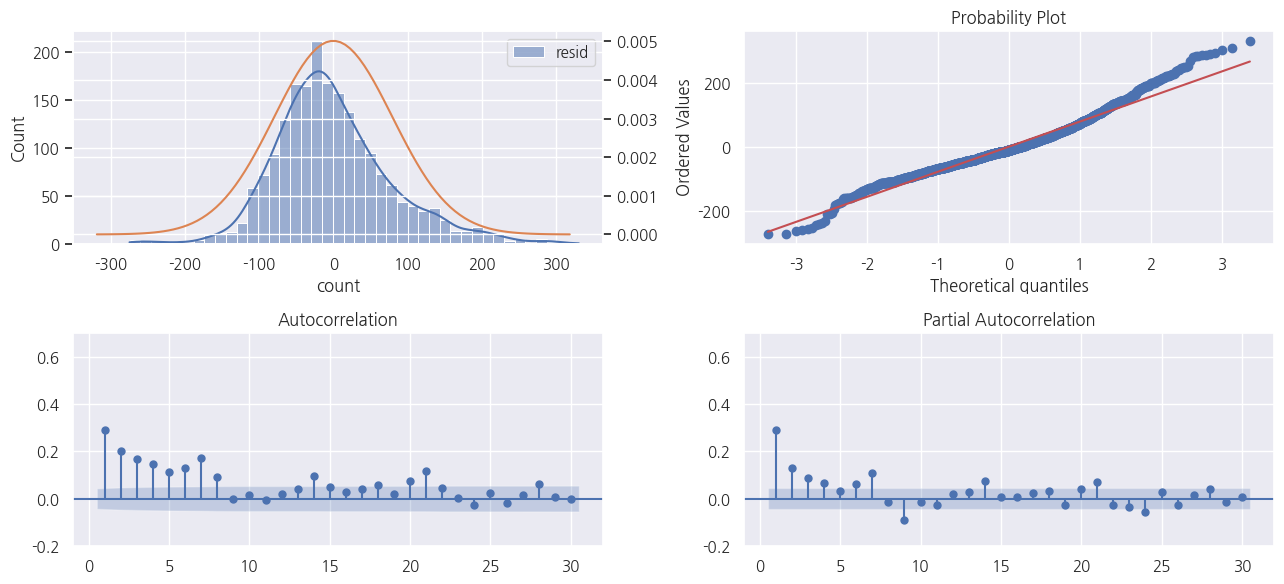

In [56]:
# 성별 분리 - 남

bd_temp = daily_bd_df[(daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])) & (daily_bd_df["gender"] == "남") & (
            daily_bd_df["region"] == "광주전남")] \
    .groupby(by="date")["count"].sum().reindex(complete_date_range).fillna(0)
bd_exog_vars = np.concatenate([dow_oh, holiday, missing_dates], axis=1)
weekly_bd_model_fit = sm.OLS(bd_temp, bd_exog_vars).fit()

_, ax = plt.subplots(1, 1, figsize=(13, 3))

target_year = 2018

weekly_bd_y_predict = weekly_bd_model_fit.predict(bd_exog_vars)
weekly_bd_resid = bd_temp - weekly_bd_y_predict
ax.plot(bd_temp, color="C1", label="true")
ax.plot(bd_temp.index, weekly_bd_y_predict, color="C0", label="estimated", alpha=0.5)

if target_year:
    ax.set_xlim([date(target_year, 1, 1), date(target_year, 12, 31)])
ax.legend(loc=1)
plt.show()

_, axs = plt.subplots(2, 2, figsize=(13, 6))
sns.histplot(weekly_bd_resid, kde=True, ax=axs[0][0], label="resid")
ax = axs[0][0].twinx()
mu, std = stats.norm.fit(weekly_bd_resid)
x_range = np.linspace(mu - std * 4, mu + std * 4, 100)
ax.plot(x_range, stats.norm.pdf(x_range, mu, std), c="C1", label=f"N({int(mu)}, {int(std)}^2)")
axs[0][0].legend()

stats.probplot(weekly_bd_resid, dist=stats.norm, plot=axs[0][1])

sgt.plot_acf(weekly_bd_resid, lags=30, zero=False, ax=axs[1][0])
sgt.plot_pacf(weekly_bd_resid, lags=30, zero=False, ax=axs[1][1])
for ax in axs[1]:
    ax.set_ylim([-0.2, 0.7])

plt.tight_layout()
plt.show()

## Harmonic regression

In [57]:
n_fourier_terms = 7
fourier_terms = make_fourier_terms(len(weekly_bd_resid), 365.25, n_fourier_terms)
monthly_bd_model_fit = sm.OLS(weekly_bd_resid, fourier_terms).fit()
print(f"{n_fourier_terms}'s R^2: {monthly_bd_model_fit.rsquared:.3f}")

print(monthly_bd_model_fit.summary())

7's R^2: 0.033
                                 OLS Regression Results                                
Dep. Variable:                  count   R-squared (uncentered):                   0.033
Model:                            OLS   Adj. R-squared (uncentered):              0.026
Method:                 Least Squares   F-statistic:                              4.884
Date:                Mon, 01 Apr 2024   Prob (F-statistic):                    5.57e-09
Time:                        16:44:33   Log-Likelihood:                         -11778.
No. Observations:                2038   AIC:                                  2.358e+04
Df Residuals:                    2024   BIC:                                  2.366e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

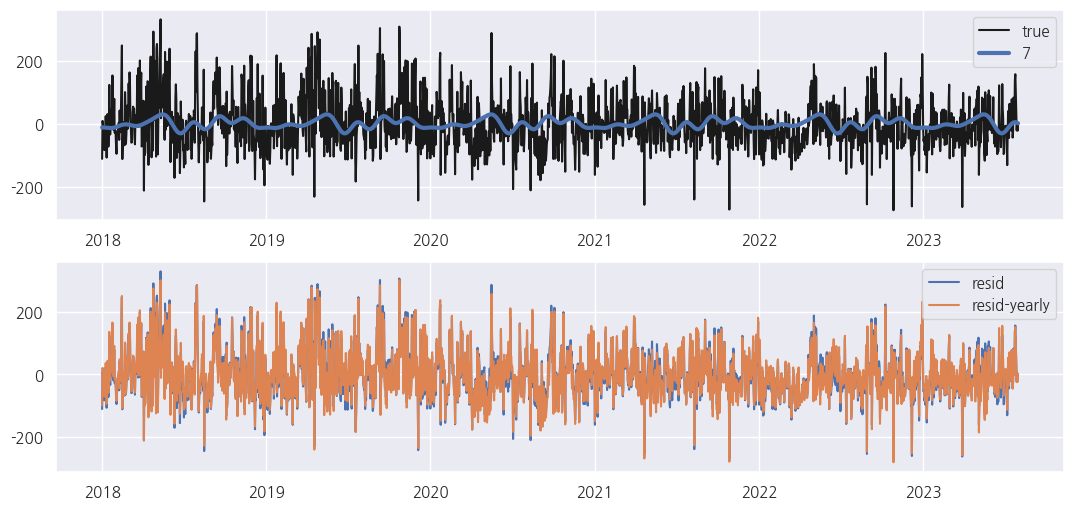

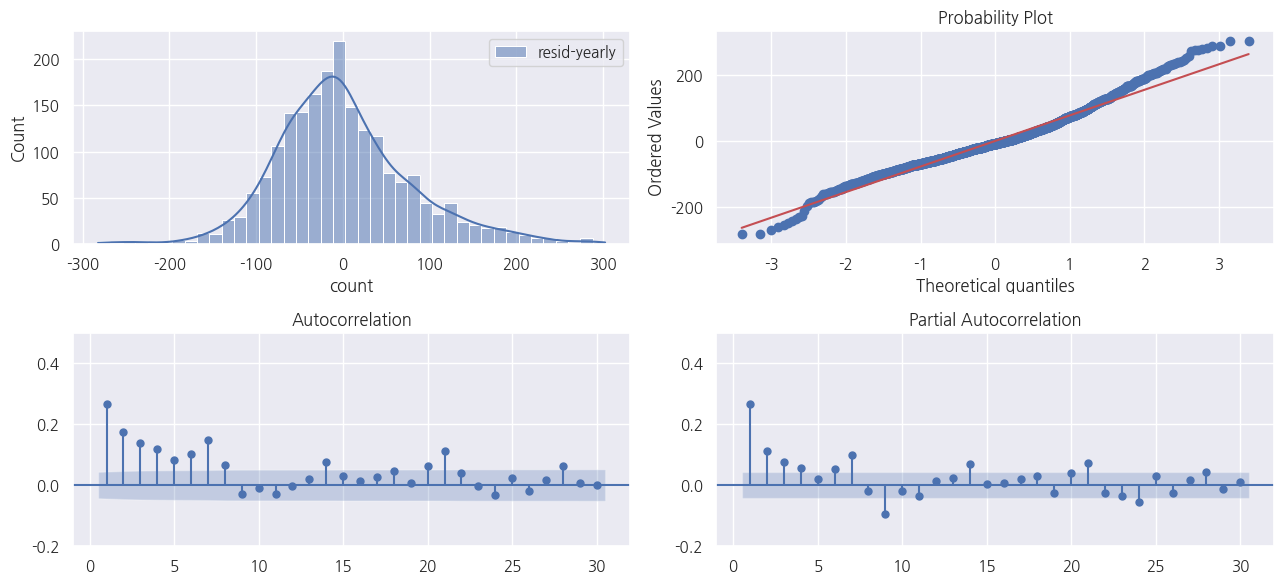

In [58]:
_, axs = plt.subplots(2, 1, figsize=(13, 6))

target_year = None

axs[0].plot(weekly_bd_resid, color="k", label="true")
# axs[0].plot(weekly_bd_resid.rolling(window=30).mean(), color="r", label="ma", alpha=0.5, linewidth=3)

monthly_bd_y_predict = monthly_bd_model_fit.predict(fourier_terms)
monthly_bd_resid = weekly_bd_resid - monthly_bd_y_predict

axs[0].plot(weekly_bd_resid.index, monthly_bd_y_predict, label=f"{n_fourier_terms}", linewidth=3)

axs[1].plot(weekly_bd_resid, label="resid")
axs[1].plot(monthly_bd_resid, label="resid-yearly")

if target_year:
    axs[0].set_xlim([date(target_year, 1, 1), date(target_year, 12, 31)])
    axs[1].set_xlim([date(target_year, 1, 1), date(target_year, 12, 31)])
axs[0].legend()
axs[1].legend()

plt.show()

_, axs = plt.subplots(2, 2, figsize=(13, 6))

# sns.histplot(weekly_bd_resid, kde=True, ax=axs[0][0], label="resid", alpha=0.5)
sns.histplot(monthly_bd_resid, kde=True, ax=axs[0][0], label="resid-yearly")
axs[0][0].legend()

stats.probplot(monthly_bd_resid, dist=stats.norm, plot=axs[0][1])

sgt.plot_acf(monthly_bd_resid, lags=30, zero=False, ax=axs[1][0])
sgt.plot_pacf(monthly_bd_resid, lags=30, zero=False, ax=axs[1][1])
for ax in axs[1]:
    ax.set_ylim([-0.2, 0.5])

plt.tight_layout()
plt.show()

                                     SARIMAX Results                                     
Dep. Variable:                             count   No. Observations:                 1826
Model:             ARIMA(1, 0, 2)x(1, 0, [1], 7)   Log Likelihood              -10503.400
Date:                           Mon, 01 Apr 2024   AIC                          21018.801
Time:                                   16:44:35   BIC                          21051.860
Sample:                               01-01-2018   HQIC                         21030.996
                                    - 12-31-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7426      0.063     11.793      0.000       0.619       0.866
ma.L1         -0.5269      0.068     -7.804

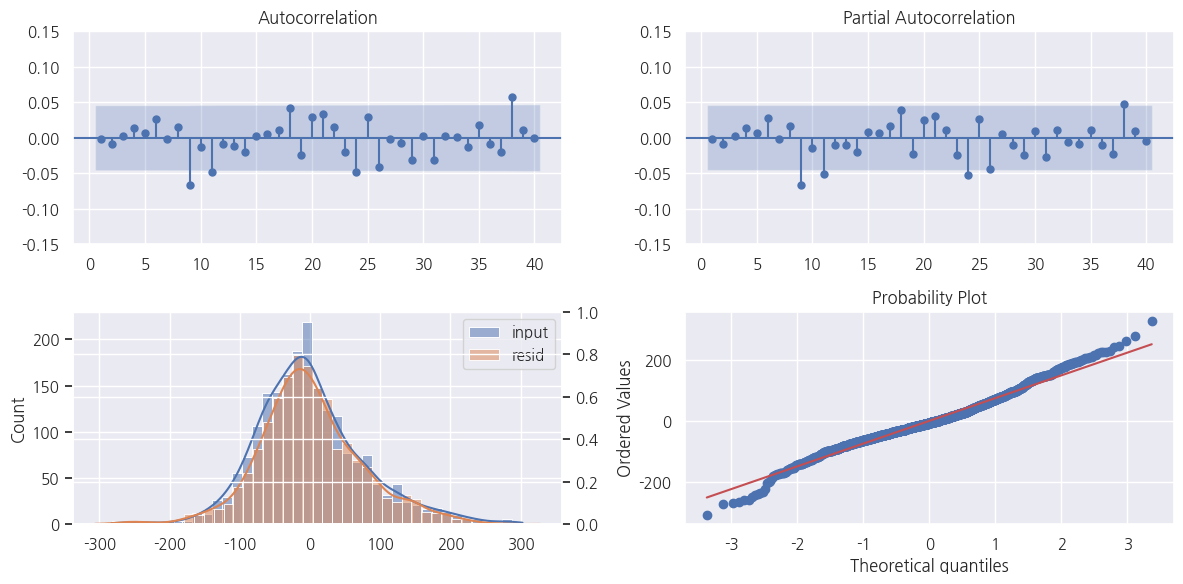

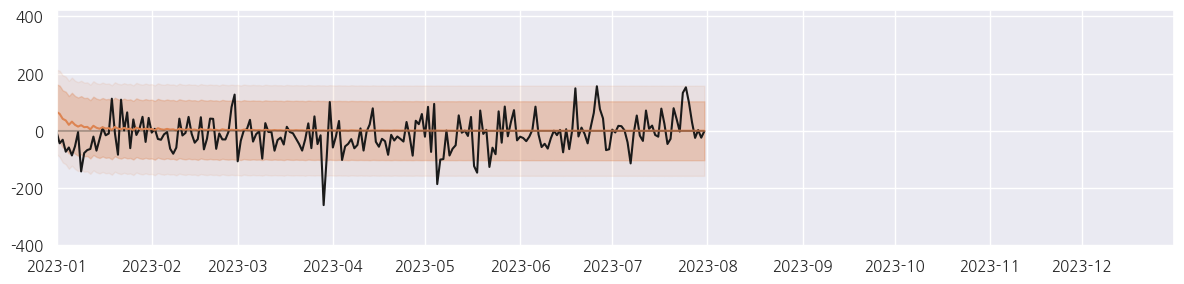

In [59]:
y_train = monthly_bd_resid[:"2022-12-31"]
y_test = monthly_bd_resid["2023-1-1":]

arima_model_fit = arima_model(y_train, y_test, None, None, summary=True, plot=True, arima_order=(1, 0, 2),
                              target_year=2023)
arima_y_predict = pd.concat([arima_model_fit.predict(), arima_model_fit.forecast(steps=len(y_test))])

## Blood usage

In [60]:
# blood donation <- blood usage
# bd vs bu 모델 잔차끼리 비교

bd_temp = daily_bd_df[daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])] \
    .groupby(by="date")["count"].sum().reindex(complete_date_range).fillna(0)
bu_temp = np.sum(daily_bu_df.values, axis=1).reshape(-1, 1)
exog_vars = np.concatenate([dow_oh, holiday, missing_dates], axis=1)
exog_vars_df = pd.DataFrame(exog_vars, columns=["mon", "tue", "wed", "thu", "fri", "sat", "sun", "holiday", "missing"],
                            index=bd_temp.index)

bd_model_fit = sm.OLS(bd_temp, exog_vars_df).fit()
# print(bd_model_fit.summary())

bu_model_fit = sm.OLS(bu_temp, exog_vars_df).fit()
# print(bu_model_fit.summary())

[[1.         0.48928699]
 [0.48928699 1.        ]]


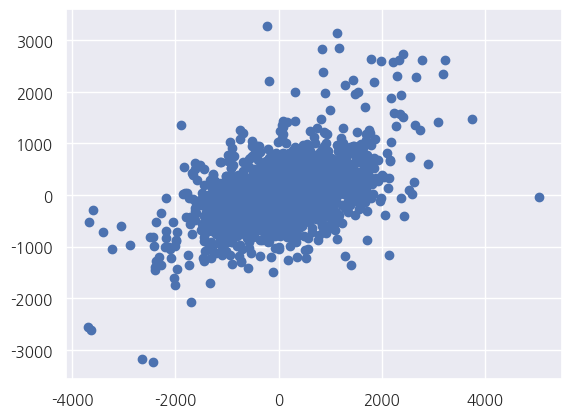

In [61]:
# Corr(bd, bu) = 0.5
plt.scatter(bd_model_fit.resid.values, bu_model_fit.resid.values)

print(np.corrcoef(bd_model_fit.resid.values, bu_model_fit.resid.values))

In [62]:
# Usage modeling
bd_temp = daily_bd_df[(daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"]))] \
    .groupby(by="date")["count"].sum().reindex(complete_date_range).fillna(0)
bd_exog_vars = np.concatenate([dow_oh, holiday, missing_dates], axis=1)
weekly_bd_model_fit = sm.OLS(bd_temp, bd_exog_vars).fit()

bu_exog_vars = np.concatenate([dow_oh, holiday, missing_dates], axis=1)
weekly_bu_model_fit = sm.OLS(bu_temp, bu_exog_vars).fit()

print(weekly_bu_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     2075.
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:44:37   Log-Likelihood:                -15788.
No. Observations:                2038   AIC:                         3.159e+04
Df Residuals:                    2029   BIC:                         3.164e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          6441.5082     33.081    194.721      0.0

## Shortage effect

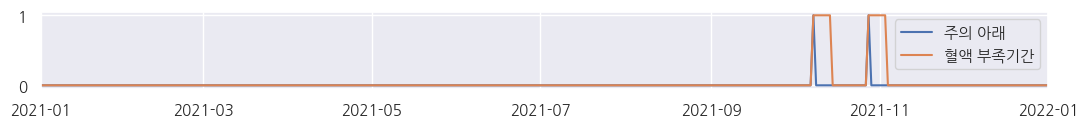

In [63]:
_, ax = plt.subplots(1, 1, figsize=(13, 1))

crisis_lack_dummy = pd.concat(
    [(bd_crisis_status < 3)] + [(bd_crisis_status < 3).shift(i, fill_value=0).astype(int) for i in range(1, 7)],
    axis=1).sum(axis=1)
crisis_lack_dummy = crisis_lack_dummy.apply(lambda x: min(x, 1))

ax.plot(bd_crisis_status < 3, label="주의 아래")
ax.plot(crisis_lack_dummy, label="혈액 부족기간")
ax.set_xlim([date(2021, 1, 1), date(2022, 1, 1)])
ax.legend()
plt.show()

In [64]:
n_fourier_terms = 5
fourier_terms = make_fourier_terms(len(bd_temp), 365.25, n_fourier_terms)

fourier_columns = []
for i in range(1, n_fourier_terms+1):
    fourier_columns.append(f"sin_{i}")
    fourier_columns.append(f"cos_{i}")
print(fourier_columns)

['sin_1', 'cos_1', 'sin_2', 'cos_2', 'sin_3', 'cos_3', 'sin_4', 'cos_4', 'sin_5', 'cos_5']


In [65]:
# 보유상태 -> 공급량
bd_temp = daily_bd_df[(daily_bd_df["method"].isin(["전혈 400ml", "전혈 320ml"])) & (daily_bd_df["gender"] == "남")] \
    .groupby(by="date")["count"].sum().reindex(complete_date_range).fillna(0)

poly = PolynomialFeatures(2, include_bias=False)
bd_dg_exog_vars = np.concatenate([bd_exog_vars, np.expand_dims(crisis_lack_dummy, axis=1)], axis=1)
bd_dg_exog_vars = pd.DataFrame(bd_dg_exog_vars,
                               columns=["mon", "tue", "wed", "thu", "fri", "sat", "sun", "holiday", "missing",
                                        "crisis"], index=bd_temp.index)

covid_period = (("2020-01-20" < bd_group.index) & (bd_group.index < "2022-03-01")).astype(int)
weekday_weekend = np.concatenate([np.sum(bd_exog_vars[:, :5], axis=1).reshape(-1, 1), bd_exog_vars[:, 5:7]], axis=1)
covid_effects = np.multiply(np.expand_dims(covid_period, axis=1), weekday_weekend)
covid_effects_df = pd.DataFrame(covid_effects, columns=["cov_weekday", "cov_sat", "cov_sun"],
                                index=bd_dg_exog_vars.index)

fourier_terms_df = pd.DataFrame(fourier_terms, columns=fourier_columns, index=bd_dg_exog_vars.index)

bd_dg_model_fit = sm.OLS(bd_temp, pd.concat([bd_dg_exog_vars, covid_effects_df, fourier_terms_df], axis=1)).fit()
print(bd_dg_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     178.6
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:44:37   Log-Likelihood:                -15930.
No. Observations:                2038   AIC:                         3.191e+04
Df Residuals:                    2015   BIC:                         3.203e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
mon          4109.7778     37.839    108.612      

In [66]:
print(
    f"감소한 헌혈자 비율: {((bd_dg_model_fit.params.values[10] * 5) + np.sum(bd_dg_model_fit.params.values[11:13])) / np.sum(bd_dg_model_fit.params.values[:7]):.2%}")

감소한 헌혈자 비율: -4.44%


In [67]:
# 보유상태 -> 사용량

bu_temp = np.sum(daily_bu_df.values, axis=1).reshape(-1, 1)

bu_model_fit = sm.OLS(bu_temp, pd.concat([bd_dg_exog_vars, covid_effects_df, fourier_terms_df], axis=1)).fit()
print(bu_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     831.2
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:44:37   Log-Likelihood:                -15693.
No. Observations:                2038   AIC:                         3.143e+04
Df Residuals:                    2015   BIC:                         3.156e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
mon          6574.0551     33.688    195.147      

In [68]:
print(
    f"감소한 사용량 비율: {((bu_model_fit.params.values[10] * 5) + np.sum(bu_model_fit.params.values[11:13])) / np.sum(bu_model_fit.params.values[:7]):.2%}")

감소한 사용량 비율: -4.28%


## Weather effect

In [69]:
# 기상
weather_model_result_list = []
region_list = list(daily_bd_df["region"].unique())
for region in region_list:
    if region[:2] == "서울":
        region_location = "서울"
    else:
        region_location = region
    bd_dg = daily_bd_df[(daily_bd_df["region"] == region) & (
            (daily_bd_df["method"] == "전혈 320ml") | (daily_bd_df["method"] == "전혈 400ml"))] \
        .groupby(by="date")["count"].sum().reindex(complete_date_range).fillna(0)

    weather_temp = weather_df[weather_df["location"] == region_location][["temp", "rainfall"]].reindex(bd_dg.index).fillna(0)

    poly = PolynomialFeatures(2, include_bias=False)
    # weather_poly_exog = poly.fit_transform(weather_temp.values)  # temp, rainfall, temp^2, temp*rainfall, rainfall^2
    bd_dg_exog_vars = np.concatenate([bd_exog_vars, weather_temp.values], axis=1)
    bd_dg_exog_vars = pd.DataFrame(bd_dg_exog_vars,
                                   columns=["mon", "tue", "wed", "thu", "fri", "sat", "sun", "holiday", "missing", "temp",
                                            "rain"], index=bd_dg.index)

    bd_dg_model_fit = sm.OLS(bd_dg, bd_dg_exog_vars).fit()
    # print(bd_dg_model_fit.summary())
    region_weather_dict = {
        "region": region,
        "temp_coef": bd_dg_model_fit.params.values[-2],
        "rain_coef": bd_dg_model_fit.params.values[-1],
        "temp_pval": bd_dg_model_fit.pvalues.values[-2],
        "rain_pval": bd_dg_model_fit.pvalues.values[-1]
    }

    weather_model_result_list.append(region_weather_dict)
pd.DataFrame(weather_model_result_list)

,region,temp_coef,rain_coef,temp_pval,rain_pval
0,강원,0.340827,-0.210325,5.580626e-02,1.430132e-01
1,부산,0.776029,-0.884594,2.801780e-02,5.697211e-08
2,서울동부,-1.778382,-0.999354,6.397700e-12,9.419353e-07
3,제주,0.318476,-0.161348,1.096048e-04,1.343156e-05
4,충북,0.515048,-0.243381,1.064880e-05,7.307666e-03
5,경기,-0.503774,-0.631622,4.048407e-02,2.446650e-04
6,경남,0.081005,-0.384208,6.996268e-01,1.383671e-03
7,광주전남,1.216030,-0.629112,1.006058e-05,2.509888e-04
8,대구경북,0.109972,-1.085706,7.266519e-01,1.544794e-04
9,대전세종충남,1.071980,-0.847277,4.325525e-05,1.799791e-05


## Region effect

In [70]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

region_list = list(daily_bd_df["region"].unique())
bs_std = bs_temp.rename("stock").reset_index(drop=True)
bs_std.update(std_scaler.fit_transform(bs_std.values.reshape(-1, 1)).reshape(-1))

region_model_fit_dict = {}
for region in region_list:
    conditions = (daily_bd_df["region"] == region) & (
            (daily_bd_df["method"] == "전혈 320ml") | (daily_bd_df["method"] == "전혈 400ml"))
    bd_region = daily_bd_df[conditions].groupby(by="date")["count"].sum().reindex(complete_date_range).fillna(0)
    bd_region = std_scaler.fit_transform(bd_region.values.reshape(-1, 1))

    crisis_dummy_df = pd.Series(crisis_lack_dummy, index=bd_dg.index, name="crisis")
    bd_exog_vars_df = pd.DataFrame(bd_exog_vars, index=bd_dg.index, columns=["mon", "tue", "wed", "thu", "fri", "sat", "sun", "holiday", "missing"])
    if region[:2] == "서울":
        region_name = "서울"
    else:
        region_name = region
    region_weather_df = weather_df[weather_df["location"] == region_name][["temp", "rainfall"]].reindex(bd_dg.index).fillna(0)
    region_model_fit = sm.OLS(bd_region, pd.concat([bd_exog_vars_df, crisis_dummy_df, covid_effects_df, fourier_terms_df, region_weather_df], axis=1)).fit()
    # region_model_fit = sm.OLS(bd_region, pd.concat([bd_exog_vars_df, covid_effects_df, bs_std], axis=1)).fit()
    region_model_fit_dict[region] = region_model_fit

region_coef_list = list(map(lambda item: item[1].params.rename(item[0]), region_model_fit_dict.items()))
region_p_value_list = list(map(lambda item: item[1].pvalues.rename(item[0]), region_model_fit_dict.items()))

display(pd.concat(region_p_value_list, axis=1).iloc[:13])

,강원,부산,서울동부,제주,충북,경기,경남,광주전남,대구경북,대전세종충남,서울남부,서울중앙,울산,인천,전북
mon,3.124381e-21,1.618361e-02,1.044988e-04,2.301311e-01,4.813702e-08,5.552366e-06,3.036562e-07,6.296406e-03,8.113391e-05,5.260160e-04,7.443057e-16,5.684989e-05,4.018134e-08,1.519906e-04,3.151682e-10
tue,3.227107e-18,2.438498e-02,6.025745e-05,3.387383e-01,9.827654e-08,7.727111e-03,5.502582e-05,4.909705e-02,1.152324e-03,1.475897e-02,8.908057e-12,5.854505e-04,1.124874e-03,1.305579e-02,1.073421e-03
wed,4.557333e-17,9.139613e-02,4.701615e-06,6.623435e-01,5.315805e-11,1.887059e-03,2.717049e-07,1.629574e-03,2.712987e-05,2.867033e-05,4.755566e-13,2.286698e-05,6.383376e-05,1.695602e-02,6.674152e-08
thu,9.944399e-20,2.951743e-02,2.272451e-05,1.548968e-01,7.880042e-11,8.140331e-02,2.459448e-06,1.291581e-03,2.027478e-04,1.853523e-01,5.857759e-13,3.618615e-04,8.443027e-04,6.260484e-02,2.105154e-08
fri,3.670558e-41,6.640214e-08,1.150151e-24,3.504927e-05,1.115144e-25,1.350863e-20,8.242658e-14,1.284659e-15,7.429485e-16,3.095757e-18,6.410649e-36,5.021993e-28,1.201028e-12,6.466604e-23,2.629265e-23
sat,8.478200e-19,7.838991e-05,1.300180e-02,2.463267e-10,9.285718e-01,3.656058e-02,7.711719e-01,2.586273e-01,5.893204e-02,7.192323e-01,1.305670e-01,1.218129e-09,6.489198e-10,1.429875e-02,6.984820e-02
sun,9.444565e-100,1.708421e-03,2.940794e-23,1.654830e-15,4.902955e-42,1.444386e-33,5.240156e-40,3.096125e-18,4.605269e-16,1.320184e-56,3.940096e-24,2.553851e-23,2.772028e-11,1.004545e-14,1.020492e-43
holiday,7.670331e-129,2.814024e-32,5.475687e-92,5.923455e-55,6.225689e-78,2.025973e-138,7.869003e-103,7.584118e-93,1.548681e-72,2.773912e-95,1.061291e-103,3.025537e-96,3.252751e-81,1.577359e-78,3.542671e-85
missing,3.630237e-03,6.207519e-10,2.297780e-10,2.623484e-04,2.378158e-06,9.304574e-06,1.047891e-03,8.677053e-06,4.089615e-07,7.252593e-10,1.205240e-07,9.766232e-12,1.045836e-03,2.044921e-12,6.640844e-04
crisis,1.247367e-03,2.285598e-01,8.196879e-03,3.195375e-01,4.561836e-01,6.978484e-02,3.416932e-03,5.699528e-01,5.518640e-01,3.332602e-02,2.592491e-04,1.592925e-02,8.118846e-01,9.555120e-04,1.331668e-04


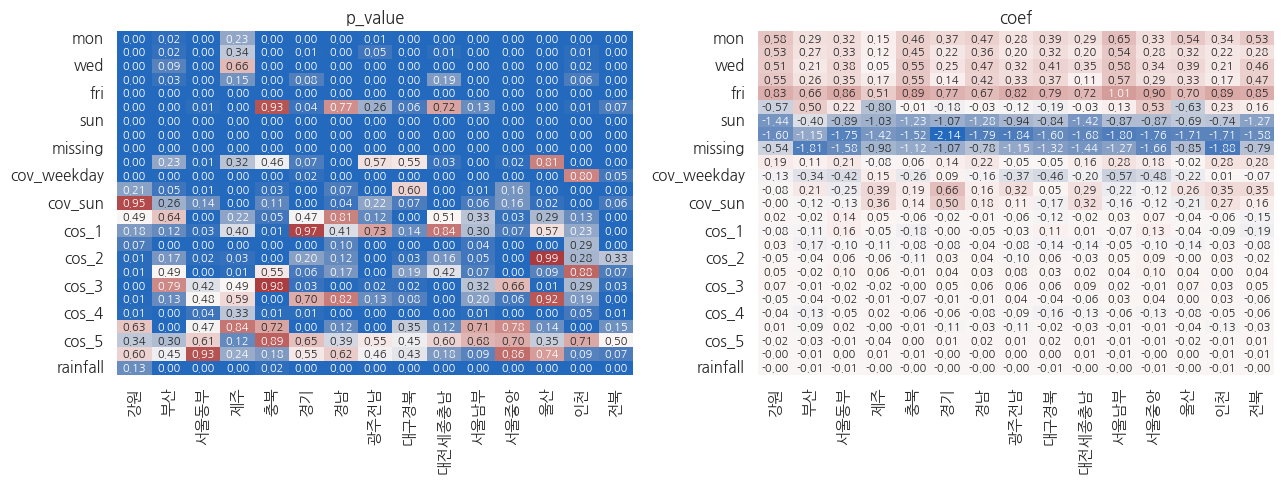

In [71]:
_, axs = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(pd.concat(region_p_value_list, axis=1), annot=True, fmt=".2f", annot_kws={"fontsize": 8}, cbar=False,
            cmap="vlag", vmin=0, vmax=1, ax=axs[0])
axs[0].set_title("p_value")
sns.heatmap(pd.concat(region_coef_list, axis=1), annot=True, fmt=".2f", annot_kws={"fontsize": 8}, cbar=False,
            cmap="vlag", center=0, ax=axs[1])
axs[1].set_title("coef")
plt.tight_layout()
plt.show()

## COVID-19 Shock

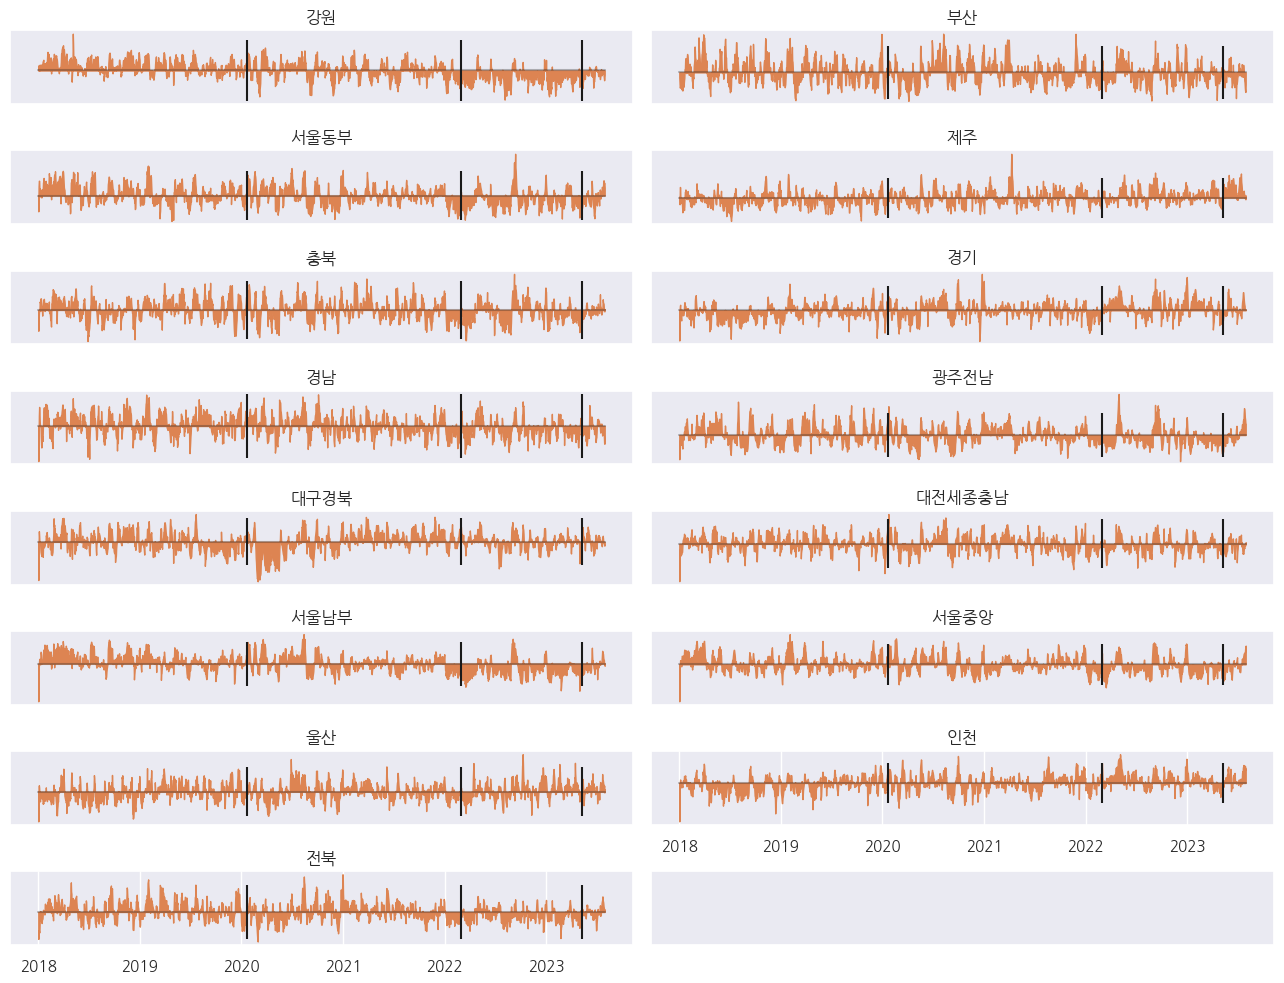

In [72]:
_, axs = plt.subplots(len(region_list) // 2 + 1, 2, figsize=(13, 10))

for i, (ax, region) in enumerate(zip(axs.flatten()[:-1], region_list)):
    ax.fill_between(bd_temp.index, region_model_fit_dict[region].resid.ewm(3).mean(), color="C1")
    ax.plot([min(bd_temp.index), max(bd_temp.index)], [0, 0], color="k", alpha=0.3)
    ax.set_title(region)
    ax.vlines(x=date(2020, 1, 20), ymin=-1, ymax=1, color="k")  # 판데믹 선언
    ax.vlines(x=date(2022, 3, 1), ymin=-1, ymax=1, color="k")  # 방역패스 해지
    ax.vlines(x=date(2023, 5, 11), ymin=-1, ymax=1, color="k")  # 비상사태 종료
    if i < len(region_list) - 2:
        ax.set_xticks([])
    ax.set_yticks([])
axs.flatten()[-1].set_xticks([])
axs.flatten()[-1].set_yticks([])

# for ax in axs[:5]:
#     ax.vlines(x=date(2020, 4, 15), ymin=-1, ymax=1, color="b") # week days (본격 확산 시작~)
#
# axs[5].vlines(x=date(2020, 5, 15), ymin=-1, ymax=1, color="b") # saturday (긴급재난지원금~)
# axs[5].vlines(x=date(2021, 12, 15), ymin=-1, ymax=1, color="b") # saturday (3차접종 ~)
#
# axs[6].vlines(x=date(2021, 4, 15), ymin=-1, ymax=1, color="b") # sunday (~예방접종 예약)

plt.tight_layout()
plt.show()